<a href="https://colab.research.google.com/github/aimlbits16/Project/blob/master/CapstoneProject_Preprocessing_Portion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Healthcare claim analytics - Denial Claim Prediction**

# ![alt text](https://drive.google.com/uc?id=1QLNdyzs_QazDPAu7kUy4BxdnI5iWmd8f)

------------------------------------------------

![alt text](https://drive.google.com/uc?id=1Z0s8iQgssyvN7VO5MgKYAUYkdMxn-1QJ)

-----

![alt text](https://drive.google.com/uc?id=1eeQG-ZXTn4jf1lEwScDOboiTiY5TPiIt)

### Due to high processing power requirement for data used in this analysis, we are executing it in Google Colab

In [0]:
# Mounting the Google drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Data Preparation

### Importing Required Libraries

In [3]:
import sys
print('python:{}'.format(sys.version))
import os


import scipy as sp
print('scipy:{}'.format(sp.__version__))
import numpy as np
print('numpy:{}'.format(np.__version__))
import pandas as pd
print('pandas:{}'.format(pd.__version__))

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

python:3.6.9 (default, Apr 18 2020, 01:56:04) 
[GCC 8.4.0]
scipy:1.4.1
numpy:1.18.3
pandas:1.0.3


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Data Reads - Required dataset is in google drive project input data folder

In [0]:
InputFolder = '/content/gdrive/My Drive/capstone-project/input_data'
OutFolder = '/content/gdrive/My Drive/capstone-project/output_data'
inFile = InputFolder + '/ZCUPClaimDNA-History-Data-v2.xlsx'
pklFile = OutFolder + '/df_data.pkl'
rawpklFile = OutFolder + '/df_data_raw.pkl'
rejectionFile = OutFolder +'/Null-Claim-Number-Records.csv'
cleanFile = OutFolder +'/Clean_Data.csv'

### Reading Data into Pandas Dataframe

In [7]:
print("Reading Main File")
df_history_dataset = pd.read_excel(inFile, 
                                   sheet_name='HistoryData',
                                   header=0,
                                   converters={'srlno':str, 
                                               'Claim.Number':str,
                                               'Claim.Line.Number':str,
                                               'Member.ID':str,
                                               'Provider.ID':str,
                                               'Revenue.Code':str,
                                               'Service.Code':str,
                                               'Place.Of.Service.Code':str,
                                               'Procedure.Code':str,
                                               'Diagnosis.Code':str,
                                               'Claim.Charge.Amount':np.float64,
                                               'Denial.Reason.Code':str,
                                               'In.Out.Of.Network':str,
                                               'Subscriber.Payment.Amount':np.float64,
                                               'Provider.Payment.Amount':np.float64,
                                               'Claim.Type':str,
                                               'Claim.Subscriber.Type':str,
                                               'Claim.Current.Status':str,
                                               'Network.ID':str,
                                               'Agreement.ID':str
                                              }, skipinitialspace=False,verbose=True,na_values=['None',''],na_filter=True,error_bad_lines=False).rename(columns=lambda x: x.strip())
print("Reading Labels File")
df_labels_dataset = pd.read_excel(inFile, 
                                  sheet_name='Accept-Denial-Label', 
                                  header=0,
                                  converters={'srlno':str, 
                                              'Label':str
                                             }, skipinitialspace=False,verbose=True,na_values=['None',''],na_filter=True,error_bad_lines=False).rename(columns=lambda x: x.strip())

print("Merging data frames")
df_data = pd.merge(df_history_dataset, df_labels_dataset, on='Srlno')
df_data.columns = df_data.columns.str.strip()

df_data_raw = df_data.copy()

Reading Main File
Reading sheet HistoryData
Reading Labels File
Reading sheet Accept-Denial-Label
Merging data frames


### Pickling the Raw data Frame for using in case of reworks -to enable accelerated reads

In [8]:
print("Pickling the Data Frame")
df_data.to_pickle(rawpklFile)
print("Pickled the Data Frame")

Pickling the Data Frame
Pickled the Data Frame


#### Picking from Pickle or raw data frame.

In [9]:
df_data = df_data_raw.copy()
df_data = pd.read_pickle(rawpklFile)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472559 entries, 0 to 472558
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Srlno                      472559 non-null  int64  
 1   Claim.Number               298536 non-null  object 
 2   Claim.Line.Number          472559 non-null  object 
 3   Member.ID                  472559 non-null  object 
 4   Provider.ID                472559 non-null  object 
 5   Revenue.Code               472559 non-null  object 
 6   Service.Code               472559 non-null  object 
 7   Place.Of.Service.Code      472559 non-null  object 
 8   Procedure.Code             472559 non-null  object 
 9   Diagnosis.Code             472559 non-null  object 
 10  Claim.Charge.Amount        472559 non-null  float64
 11  Denial.Reason.Code         472559 non-null  object 
 12  In.Out.Of.Network          472559 non-null  object 
 13  Subscriber.Payment.Amount  47

###  Replace all Columns having blanks, just multiple white spaces with NAN

In [10]:
df_data.replace(r'^\s*$',np.NAN, regex=True,inplace=True)
#df_data.loc[df_data['Member.ID'].isin([' ']), 'Member.ID'] = None
#df_data.loc[df_data['Subscriber.Payment.Amount'].isin([' ']), 'Subscriber.Payment.Amount'] = np.nan
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472559 entries, 0 to 472558
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Srlno                      472559 non-null  int64  
 1   Claim.Number               298536 non-null  object 
 2   Claim.Line.Number          472559 non-null  object 
 3   Member.ID                  472559 non-null  object 
 4   Provider.ID                472559 non-null  object 
 5   Revenue.Code               472203 non-null  object 
 6   Service.Code               472013 non-null  object 
 7   Place.Of.Service.Code      403 non-null     object 
 8   Procedure.Code             296928 non-null  object 
 9   Diagnosis.Code             472559 non-null  object 
 10  Claim.Charge.Amount        472559 non-null  float64
 11  Denial.Reason.Code         146529 non-null  object 
 12  In.Out.Of.Network          267637 non-null  object 
 13  Subscriber.Payment.Amount  47

### Claim number alongwith claim line number is the unique identifier that identifies each line in the data file uniquely. Any rows with blank claim number are bad data. Writing Blank Claim Numbers into a Separate File and deleting rows that do not have a claim number

In [11]:
df_data[df_data['Claim.Number'].isnull()].to_csv(rejectionFile,index=False)

#Dropping Rows with a Blank Claim Number

df_data.drop(df_data[df_data['Claim.Number'].isnull()].index,axis=0,inplace=True)
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 298536 entries, 0 to 472558
Data columns (total 21 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Srlno                      298536 non-null  int64  
 1   Claim.Number               298536 non-null  object 
 2   Claim.Line.Number          298536 non-null  object 
 3   Member.ID                  298536 non-null  object 
 4   Provider.ID                298536 non-null  object 
 5   Revenue.Code               298365 non-null  object 
 6   Service.Code               298025 non-null  object 
 7   Place.Of.Service.Code      170 non-null     object 
 8   Procedure.Code             212449 non-null  object 
 9   Diagnosis.Code             298536 non-null  object 
 10  Claim.Charge.Amount        298536 non-null  float64
 11  Denial.Reason.Code         146529 non-null  object 
 12  In.Out.Of.Network          267637 non-null  object 
 13  Subscriber.Payment.Amount  29

### Creating a new column with Claim.Number and Claim.Line.Number and Deleting duplicate rows based on this new column

In [12]:
print ('No. Of Claim Number that are Null or not provided:{0}'.format(df_data['Claim.Number'].isnull().sum()))

df_data[df_data['Claim.Number'].duplicated(keep=False)]['Claim.Number'].count()

df_data['Claim.Number.Claim.Line.Number'] = df_data['Claim.Number'] + df_data['Claim.Line.Number']

duplicate_claim_number_claim_line_number = df_data[df_data['Claim.Number.Claim.Line.Number'].duplicated(keep=False)]
duplicate_count = duplicate_claim_number_claim_line_number['Claim.Number.Claim.Line.Number'].count()

print ('No Of Duplicate Rows =',duplicate_count)

df_data.drop(duplicate_claim_number_claim_line_number['Claim.Number.Claim.Line.Number'].index[1:duplicate_count],axis=0,inplace=True)

No. Of Claim Number that are Null or not provided:0
No Of Duplicate Rows = 196


### Rows with label zero (0 - Accepted) without any Denial.Reason.Code (blank) should be kept. Any row with label Zero with a value in Denial.Reason.Code (Not blank) should be Deleted

In [13]:
print(df_data[(df_data['Label'] == '0') & (df_data['Denial.Reason.Code'].notnull())][['Denial.Reason.Code','Label']].count())
print('Distribution:\n{}'.format((df_data['Label'].value_counts()/ df_data['Label'].count())*100))
df_data.drop(df_data[(df_data['Label'] == '0') & (df_data['Denial.Reason.Code'].notnull())].index,axis=0,inplace=True)
print(df_data[(df_data['Label'] == '0') & (df_data['Denial.Reason.Code'].notnull())][['Denial.Reason.Code','Label']].count())

Denial.Reason.Code    144465
Label                 144465
dtype: int64
Distribution:
0    99.339347
1     0.660653
Name: Label, dtype: float64
Denial.Reason.Code    0
Label                 0
dtype: int64


### Finding missing values in each column in the data frame

In [14]:
#% of missing values in each column:
def find_missing_values_func(df):    # Input parameter is dataframe        
    mis_val = df.isnull().sum()        
    mis_val_percent = 100 * df.isnull().sum() / len(df)        
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)        
    mis_val_table_ren_columns = mis_val_table.rename(        
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})        
    mis_val_table_ren_columns = mis_val_table_ren_columns[            
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(        
        '% of Total Values', ascending=False).round(1)        
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"               
           "There are " + str(mis_val_table_ren_columns.shape[0]) +              
           " columns that have missing values.")        
    return mis_val_table_ren_columns

def drop_missing_values(df, percentage):
    columns = df.columns
    percent_missing = df.isnull().sum()*100/len(df)
    missing_value_df = pd.DataFrame({'column_name': columns, 'percent_missing':percent_missing})
    missing_drop = list(missing_value_df[missing_value_df.percent_missing>percentage].column_name)
    df = df.drop(missing_drop, axis=1)
    return df

print(find_missing_values_func(df_data))

Your selected dataframe has 22 columns.
There are 8 columns that have missing values.
                       Missing Values  % of Total Values
Place.Of.Service.Code          153742               99.9
Denial.Reason.Code             151905               98.7
Procedure.Code                  58349               37.9
Network.ID                      28477               18.5
In.Out.Of.Network               28151               18.3
Agreement.ID                    28151               18.3
Service.Code                      511                0.3
Revenue.Code                      135                0.1


### Finding distribution of records between the two labels

In [15]:
print(df_data['Label'].value_counts())
print('Distribution:\n{}'.format((df_data['Label'].value_counts()/ df_data['Label'].count())*100))

0    151905
1      1971
Name: Label, dtype: int64
Distribution:
0    98.719098
1     1.280902
Name: Label, dtype: float64


## Lets look at the distribution of the target variable 'Label' across the two values i.e 0 & 1

0    151905
1      1971
Name: Label, dtype: int64


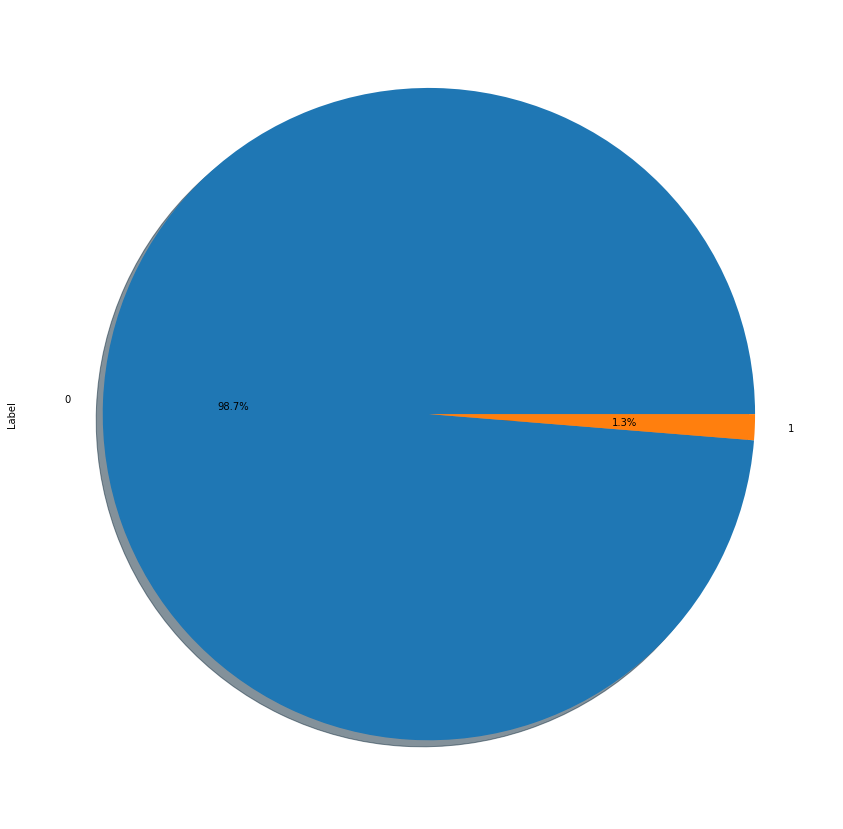

In [18]:
print(df_data['Label'].value_counts())
labels = [df_data['Label'].unique()]
df_data['Label'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

### ** This clearly indicates that the dataset provided is imbalanced**

## **Analysis of Revenue code, Service Code, Diagnosis Code, Procedure Code**

## Lets look at the distribution of the Revenue.Code across all the categories available


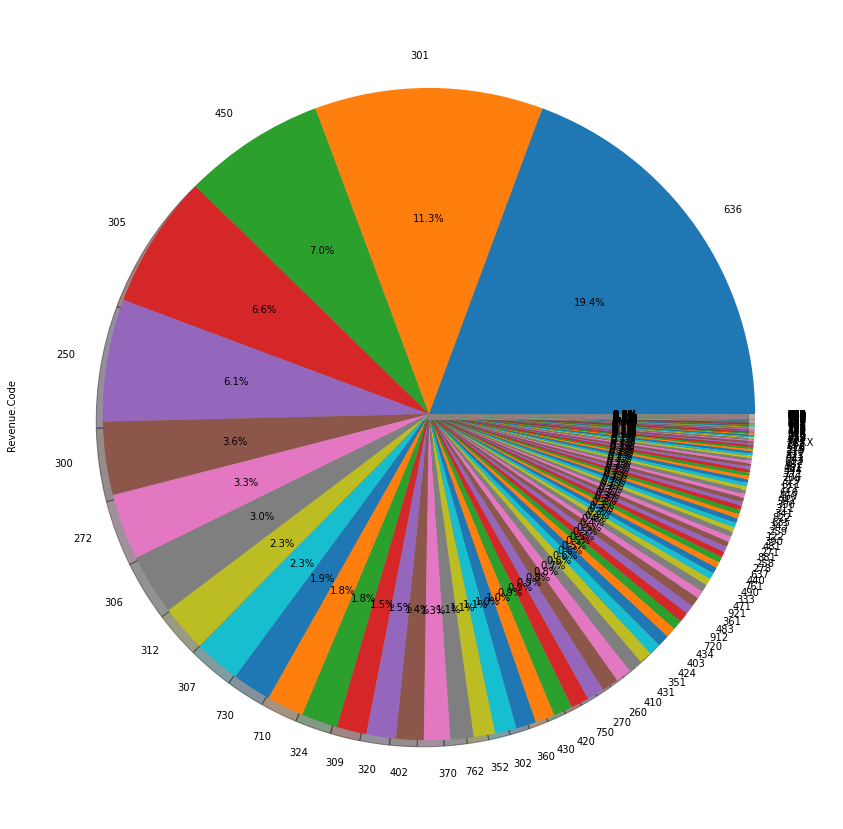

In [19]:
df_data['Revenue.Code'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

## Lets look at the distribution of Revenue.Code by Label to understand which Revenue Codes contribute to the Label 0 and which contribute to Label 1

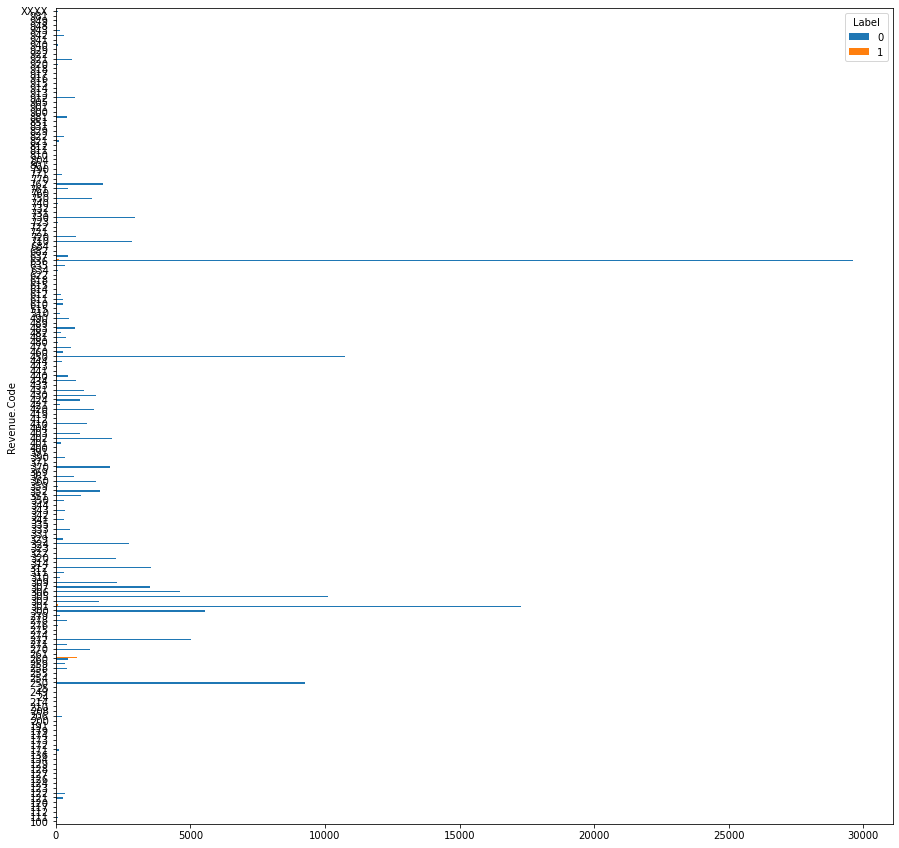

In [20]:
pd.crosstab(df_data['Revenue.Code'],df_data['Label']).plot.barh(figsize=(15, 15))

## Lets look at the distribution of the Service.Code across all the categories available

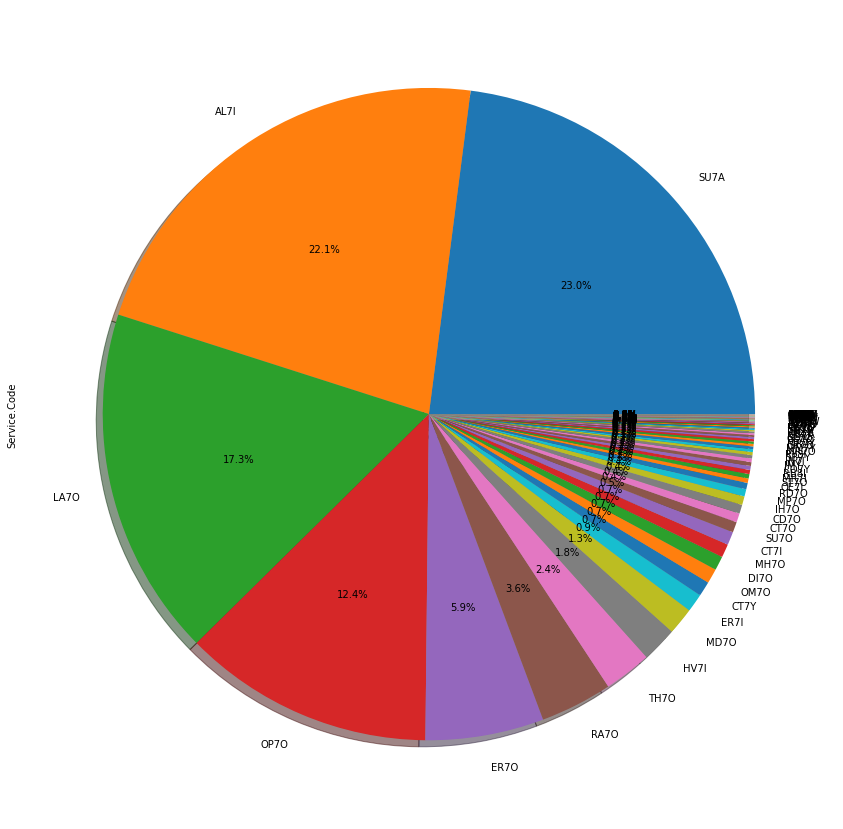

In [21]:
df_data['Service.Code'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

## Lets look at the distribution of Service.Code by Label to understand which Revenue Codes contribute to the Label 0 and which contribute to Label 1

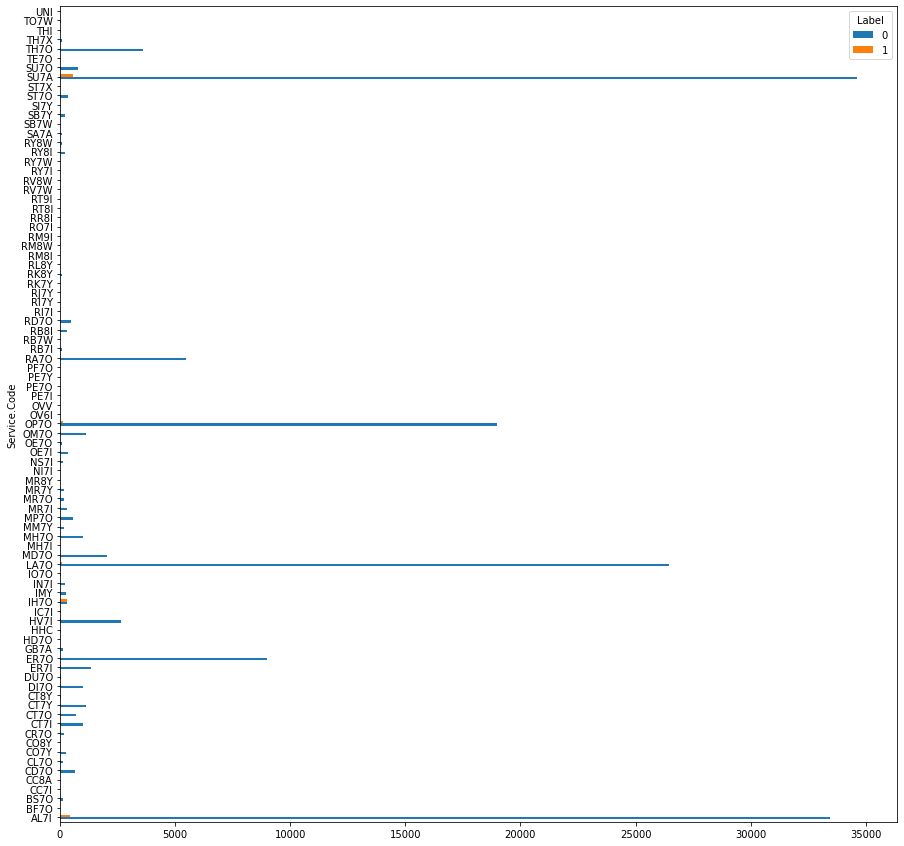

In [22]:
pd.crosstab(df_data['Service.Code'],df_data['Label']).plot.barh(figsize=(15, 15))

## Lets look at the distribution of the Diagnosis.Code across all the categories available

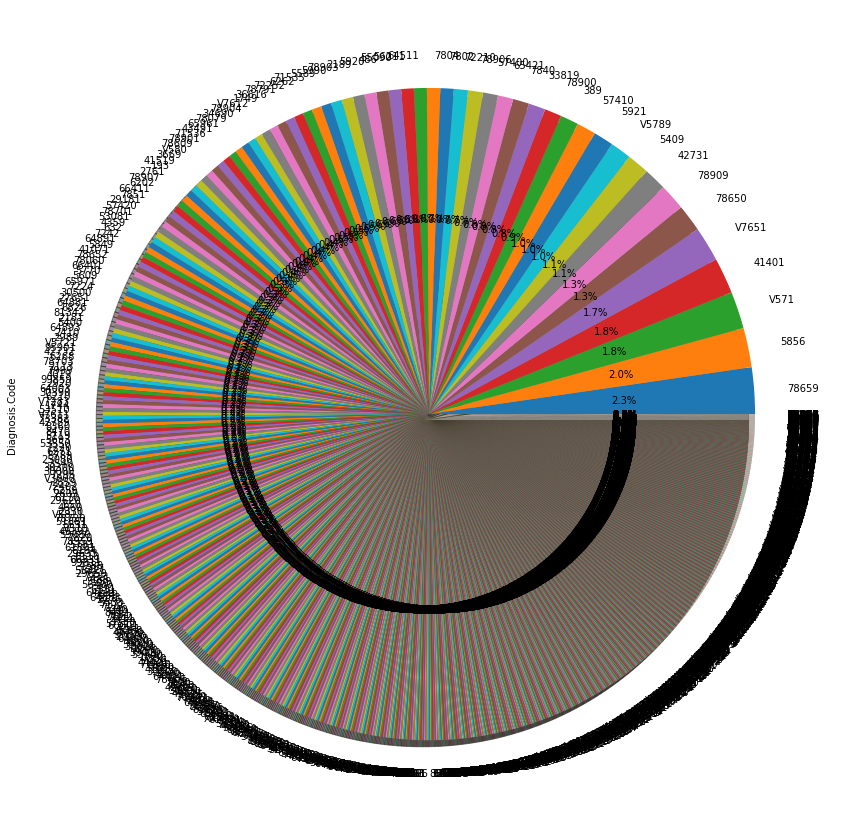

In [23]:
df_data['Diagnosis.Code'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))


## Lets look at the distribution of Diagnosis.Code by Label to understand which Revenue Codes contribute to the Label 0 and which contribute to Label 1

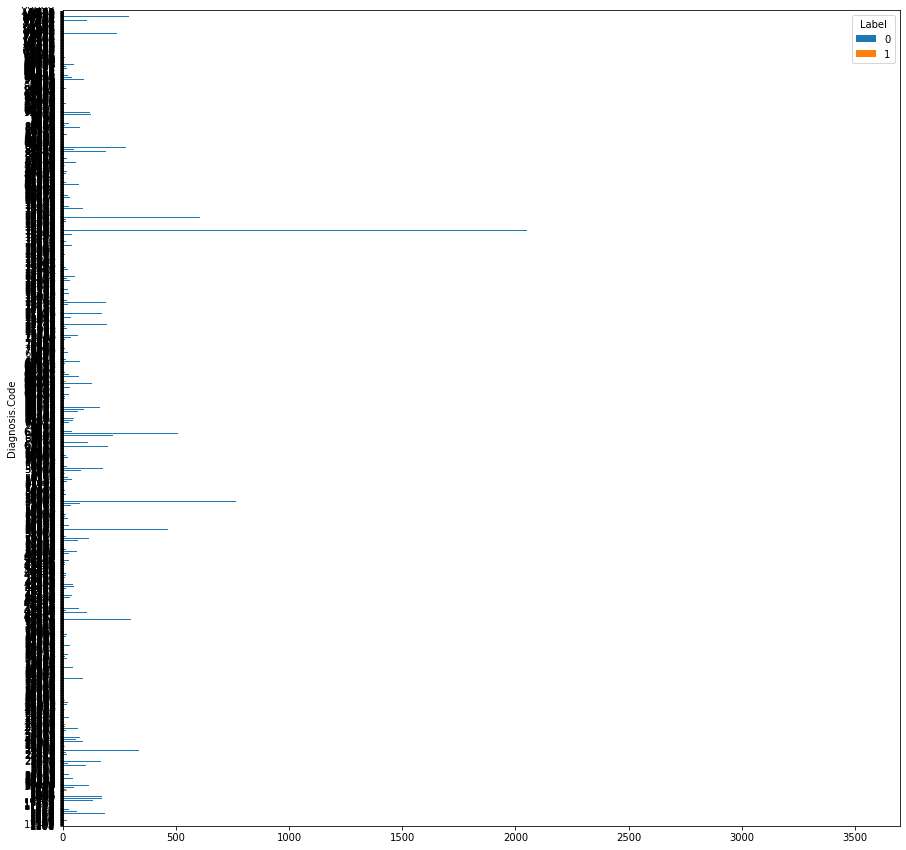

In [24]:
pd.crosstab(df_data['Diagnosis.Code'],df_data['Label']).plot.barh(figsize=(15, 15))

### Lets look at the distribution of the Procedure.Code across categories available

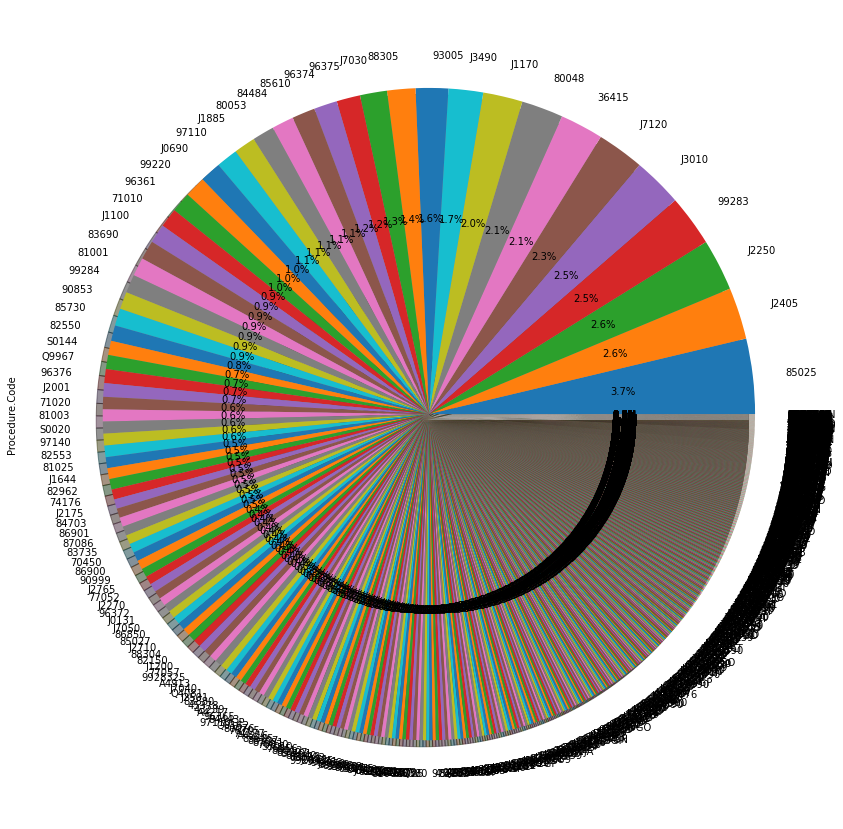

In [25]:
df_data['Procedure.Code'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

## **Conclusion there are far too many categories and they need to be collapsed into 3/4 Groups either using the business logic provided by the Domain expert or using binning when no business logic is provided**

## Lets Identify the Outliers amoungst the Numeric Columns to understand the distribution

### We are yet to decide what to do with outliers

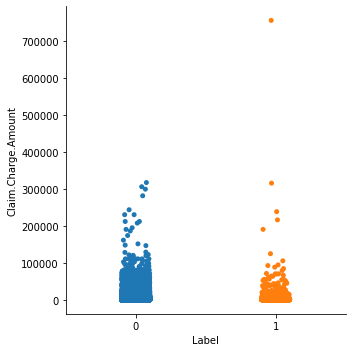

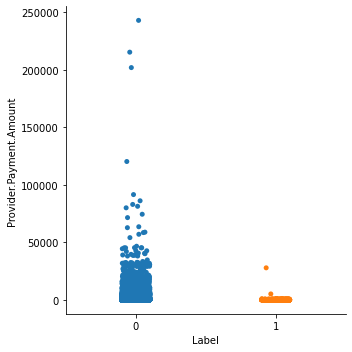

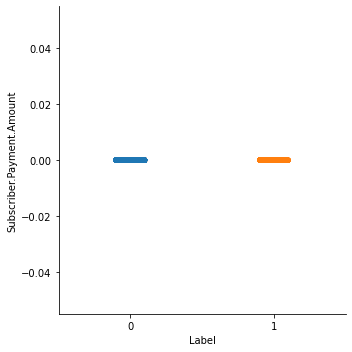

In [26]:
numerical_columns = ["Claim.Charge.Amount", "Provider.Payment.Amount","Subscriber.Payment.Amount"]
sns.catplot(x='Label', y='Claim.Charge.Amount', data=df_data)
sns.catplot(x='Label', y='Provider.Payment.Amount', data=df_data)
sns.catplot(x='Label', y='Subscriber.Payment.Amount', data=df_data)

## **Conclusion: Drop outliers and do Normalization for Numerical fields. Subscriber Payment Amount is mostly zero and so column should be dropped **

## Binning for categorical values

### Revenue Code

2    140129
3      6876
1      6871
Name: Revenue.Code.Group, dtype: int64


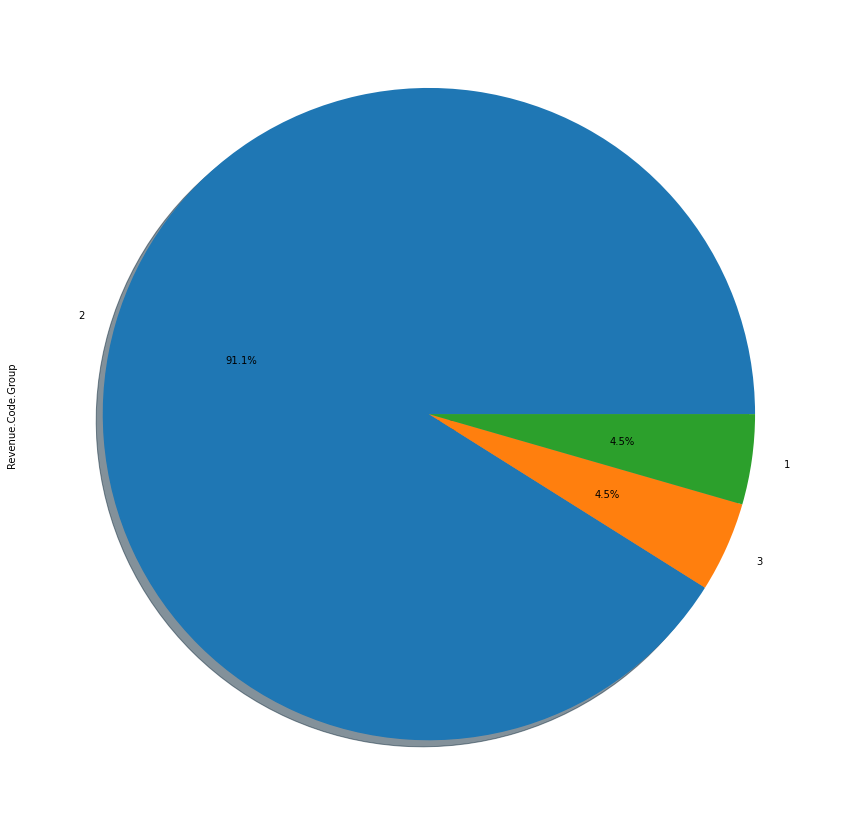

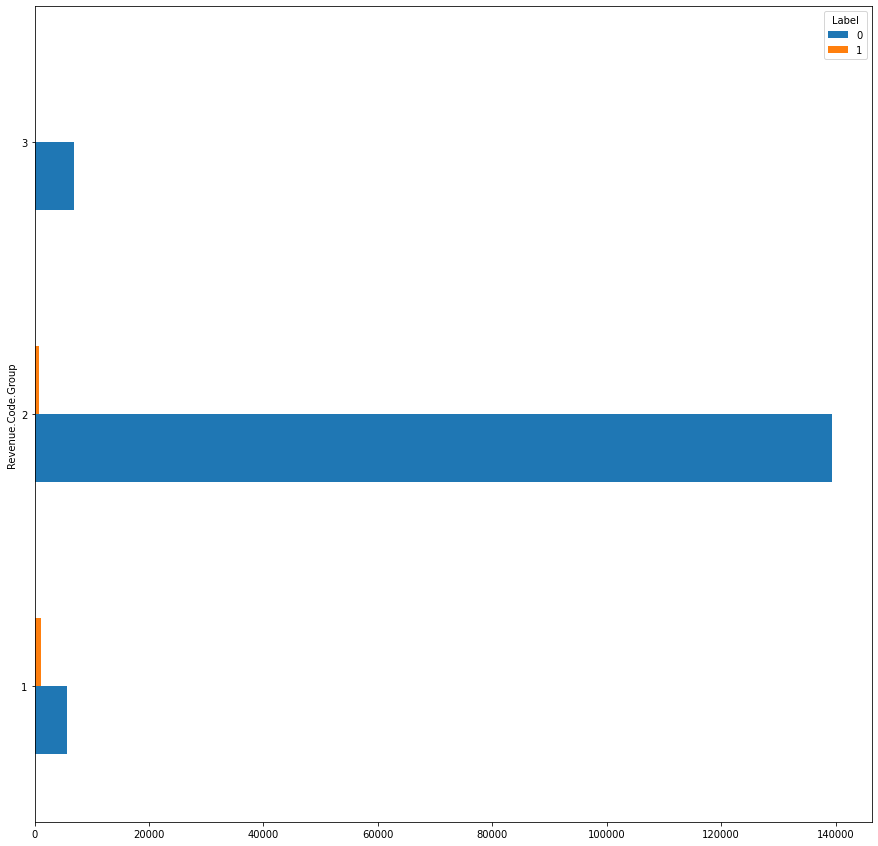

In [27]:
High_Revenue_Code = ["810", "811", "124", "261", "260", "331", "914", "174", "634", "173", "682", "126", "128", "172", "127", "200", "821", "134", "302", "740", "249", "270", "771", "361", "310", "434"]
Medium_Revenue_Code= ["210", "275", "122", "610", "206", "258", "444", "278", "117", "259", "121", "112", "276", "731", "750", "460", "360", "271", "730", "307", "424", "370", "250", "410", "940", "305", "350", "921", "480", "111", "351", "920", "636", "309", "300", "390", "301", "450", "440", "306", "311", "324", "710", "341", "272", "343", "942", "171", "482", "420", "490", "483", "312", "481", "352", "510", "402", "320", "720", "762", "761", "430", "403"]

df_data.loc[df_data['Revenue.Code'].isin(High_Revenue_Code), 'Revenue.Code.Group'] = "1"
df_data.loc[df_data['Revenue.Code'].isin(Medium_Revenue_Code), 'Revenue.Code.Group' ] = "2"
df_data.loc[~df_data['Revenue.Code'].isin(High_Revenue_Code + Medium_Revenue_Code), 'Revenue.Code.Group'] = "3"
print(df_data['Revenue.Code.Group'].value_counts())

#lets look at the distribution of the Revenue.Code.Group across all the categories available
df_data['Revenue.Code.Group'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

#lets look at the distribution of Revenue.Code by Label to understand which Revenue Codes contribute to the 
# Label 0 and which contribute to Label 1
pd.crosstab(df_data['Revenue.Code.Group'],df_data['Label']).plot.barh(figsize=(15, 15))

### Since the distribution is skewed, further binning the revenue code

### Service Code

2    108430
1     38070
3      7376
Name: Service.Code.Group, dtype: int64


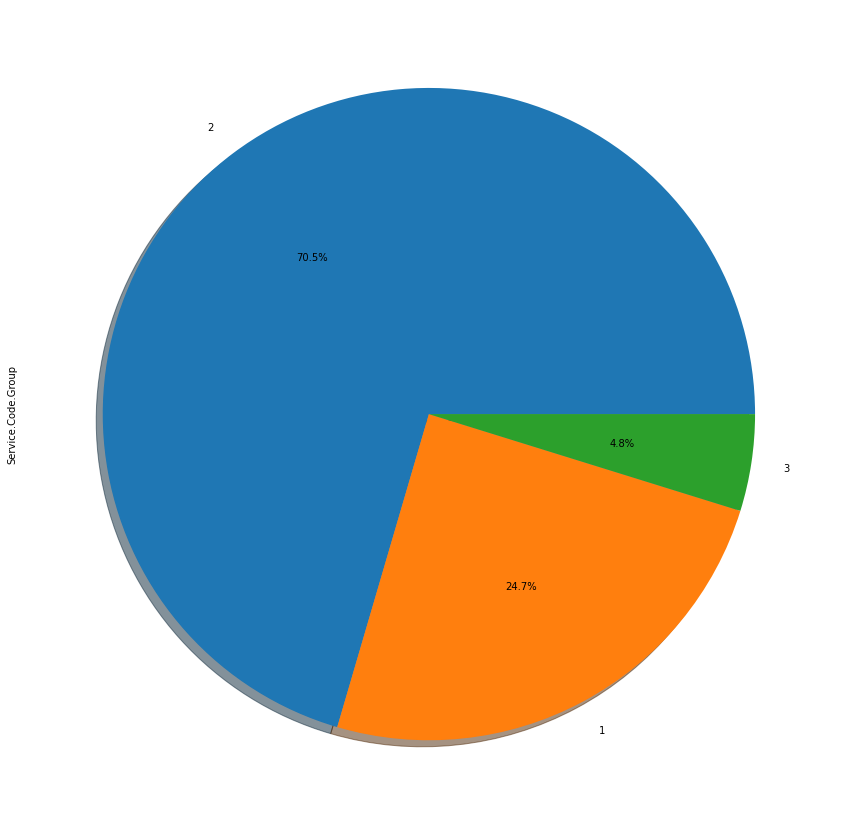

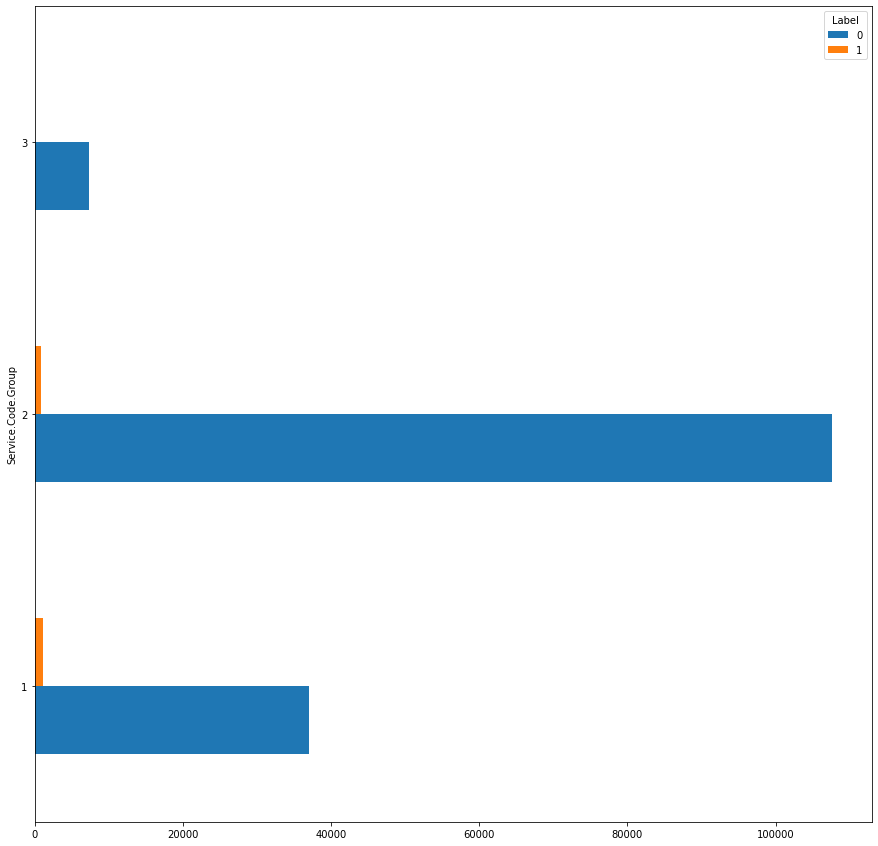

In [28]:
High_Service_Code = ["UNI", "RL8Y", "RM8W", "DU7O", "IH7O", "RM8I", "RI7Y", "SB7W", "GB7A", "NI7I", "OVV", "RM9I", "RR8I", "IMY", "RT8I", "RY8W", "RY7I", "IC7I", "SU7A", "ER7I"]
Medium_Service_Code = ["TO7W", "TE7O", "CC7I", "HV7I", "MR7O", "IN7I", "AL7I", "DI7O", "CT8Y", "RB7W", "RV8W", "CT7I", "RB8I", "RK8Y", "RB7I", "OE7I", "RY8I", "OP7O", "LA7O", "NS7I", "CL7O", "MR7Y", "ER7O", "CT7Y", "CT7O", "RA7O", "MD7O", "TH7O"]
df_data.loc[df_data['Service.Code'].isin(High_Service_Code), 'Service.Code.Group'] = '1'
df_data.loc[df_data['Service.Code'].isin(Medium_Service_Code), 'Service.Code.Group'] = '2'
df_data.loc[~df_data['Service.Code'].isin(High_Service_Code + Medium_Service_Code), 'Service.Code.Group'] = '3'
print(df_data['Service.Code.Group'].value_counts())


#lets look at the distribution of the Service.Code.Group across all the categories available
df_data['Service.Code.Group'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

#lets look at the distribution of Revenue.Code by Label to understand which Revenue Codes contribute to the 
# Label 0 and which contribute to Label 1
pd.crosstab(df_data['Service.Code.Group'],df_data['Label']).plot.barh(figsize=(15, 15))

### Diagnosis Code

2    77465
3    74600
1     1811
Name: Diagnosis.Code.Group, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 153876 entries, 0 to 472558
Data columns (total 25 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Srlno                           153876 non-null  int64  
 1   Claim.Number                    153876 non-null  object 
 2   Claim.Line.Number               153876 non-null  object 
 3   Member.ID                       153876 non-null  object 
 4   Provider.ID                     153876 non-null  object 
 5   Revenue.Code                    153741 non-null  object 
 6   Service.Code                    153365 non-null  object 
 7   Place.Of.Service.Code           134 non-null     object 
 8   Procedure.Code                  95527 non-null   object 
 9   Diagnosis.Code                  153876 non-null  object 
 10  Claim.Charge.Amount             153876 non-null  float64
 11  Deni

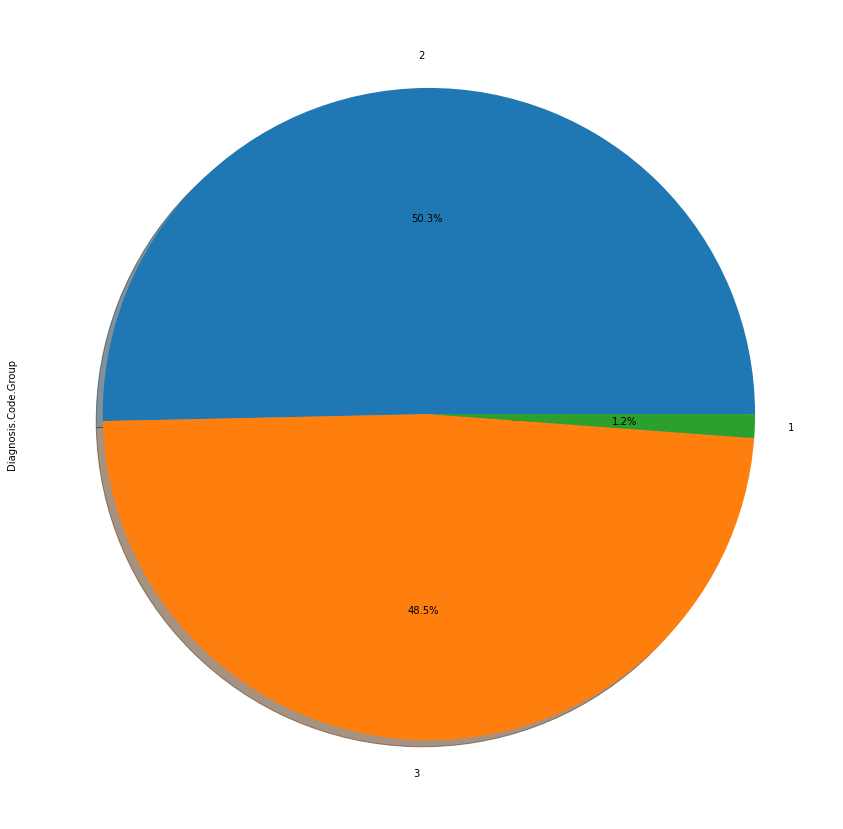

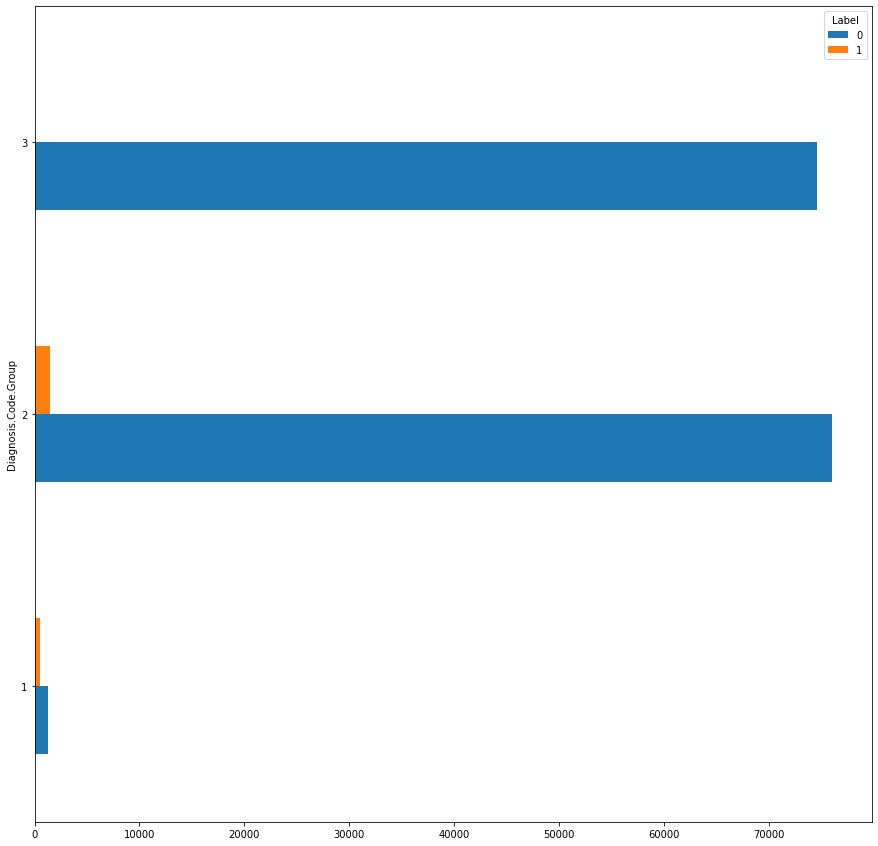

In [29]:
High_Diagnosis_Code = ["2929", "29690", "V202", "29663", "29622", "9962", "67524", "5193", "V045", "29530", "7999", "430", "29664", "5711", "79095", "30411", "29189", "6162", "29570", "29630", "29644", "5289", "20240", "99741", "37943", "9352", "V08", "V1255", "V5041", "80225", "6108", "57480", "5070", "V6284", "52460", "8024", "99681", "V3101"]
Medium_Diagnosis_Code = ["75249", "71100", "29660", "78722", "2273", "6868", "64844", "73671", "37730", "61804", "6146", "V5831", "2989", "7503", "72992", "29181", "2452", "80841", "8250", "66111", "9950", "29640", "9220", "99563", "7222", "29650", "65811", "29632", "52403", "99676", "27541", "4168", "2102", "2182", "0090", "34691", "5738", "68100", "2776", "1809", "5362", "29633", "29680", "61801", "34290", "72990", "64981", "2912", "6170", "1746", "6183", "78499", "52489", "53551", "42823", "30501", "3682", "V3000", "7226", "64303", "24200", "8832", "57470", "9726", "29689", "5409", "8248", "73730", "2181", "57450", "85011", "6121", "64893", "6253", "99883", "96501", "193", "53190", "6268", "42841", "226", "57400", "4280", "1960", "69589", "2777", "2180", "1743", "1742", "179", "6110", "6272", "60001", "53240", "V552", "6827", "5559", "6185", "8600", "81305", "07054", "0479", "45340", "6824", "5551", "38611", "5941", "2271", "72888", "80703", "6227", "6823", "6184", "4377", "62212", "72210", "2891", "5533", "5722", "8246", "V510", "6111", "2572", "2720", "5789", "55321", "3688", "2189", "2410", "1541", "5856", "65231", "6262", "5609", "5641", "7455", "1550", "2875", "220", "78720", "30300", "81209", "566", "99812", "56032", "4321", "1745", "78630", "5119", "5400", "34590", "57511", "30400", "4940", "5770", "25201", "75612", "78057", "6181", "61179", "1749", "27651", "73819", "78799", "00845", "56400", "99832", "5712", "4589", "42741", "78701", "4659", "57420", "30500", "7804", "30391", "5693", "1744", "6100", "41401", "55092", "5589", "61172", "99674", "1741", "61189", "49392", "82525", "9351", "V5331", "2910", "78901", "5303", "80126", "6271", "2141", "7842", "59970", "25002", "78791", "1748", "8500", "78900", "217", "1985", "79389", "42731", "78906", "99673", "7384", "78009", "650", "6210", "51881", "81342", "78659", "72402", "56210", "2851", "49322", "486", "55090", "2920", "56211", "V700", "57410", "4359", "5921", "03849", "78903", "53550", "7840", "2330", "64403", "33819", "6826", "78907", "V5811", "6202", "78652", "431", "V6759", "78079", "72252", "7802", "2809", "V7651", "7295", "78650", "65421", "0389", "43491", "78909", "2859", "V7611", "V7612", "3669", "V5789", "V571"]

df_data.loc[df_data['Diagnosis.Code'].isin(High_Diagnosis_Code), 'Diagnosis.Code.Group'] = '1'
df_data.loc[df_data['Diagnosis.Code'].isin(Medium_Diagnosis_Code), 'Diagnosis.Code.Group'] = '2',
df_data.loc[~df_data['Diagnosis.Code'].isin(High_Diagnosis_Code + Medium_Diagnosis_Code), 'Diagnosis.Code.Group'] = '3'
print(df_data['Diagnosis.Code.Group'].value_counts())

#lets look at the distribution of the Diagnosis.Code.Group across all the categories available
df_data['Diagnosis.Code.Group'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

#lets look at the distribution of Revenue.Code by Label to understand which Revenue Codes contribute to the 
# Label 0 and which contribute to Label 1
pd.crosstab(df_data['Diagnosis.Code.Group'],df_data['Label']).plot.barh(figsize=(15, 15))

df_data.info()


### Procedure Code

### Treatements done on members do not require any procedure to be undertaken, but deleting the rows that have null values for the Procedure.Code is not advisable as the Claims without Procedure Code do have Label of 0 AND 1 

In [31]:
print ('Number of Null Values in Procedure Code: {0}'.format(df_data['Procedure.Code'].isnull().sum()))
counts = df_data[df_data['Procedure.Code'].isnull()]['Label'].value_counts()
print ('Distribution of Procedure Code which has Null values by Label 0:{0}, Label 1:{1}'.format(counts[0],counts[1]))


Number of Null Values in Procedure Code: 58349
Distribution of Procedure Code which has Null values by Label 0:57688, Label 1:661


###Changing the Procedure.Code which has Null values to 'Others' as the it has significant assignment of Label which can be used for the Machine Learning


In [0]:
df_data.loc[df_data['Procedure.Code'].isnull(),'Procedure.Code'] = 'Others'

### The number of unique Procedure Code is very high and needs to be reduced 


In [33]:
print ('No Of Unique Procedure Codes:{0}'.format(df_data['Procedure.Code'].nunique()))

No Of Unique Procedure Codes:2240


### Lets look at the distribution of top 5 Procedure.Code




In [34]:
print ('Top 5 Procedure Code Distribution')
print (df_data['Procedure.Code'].value_counts()[:5])

Top 5 Procedure Code Distribution
Others    58349
85025      3556
J2405      2449
J2250      2448
99283      2417
Name: Procedure.Code, dtype: int64


### Binning the Procedure.Code into 5 Groups 
Group 1 : Procedure Code : 85025
Group 2 : Procedure Code : 36415
Group 3 : Procedure Code : 80048
Group 4 : Procedure Code : 99283
Group 5 : Procedure Code : Others plus remaining

Distribution Of Procedure Code Group
5    143882
1      3556
4      2417
2      2047
3      1974
Name: Procedure.Code.Group, dtype: int64
Procedure.Code.Group  Label
1                     0          3551
                      1             5
2                     0          2042
                      1             5
3                     0          1971
                      1             3
4                     0          2415
                      1             2
5                     0        141926
                      1          1956
Name: Label, dtype: int64


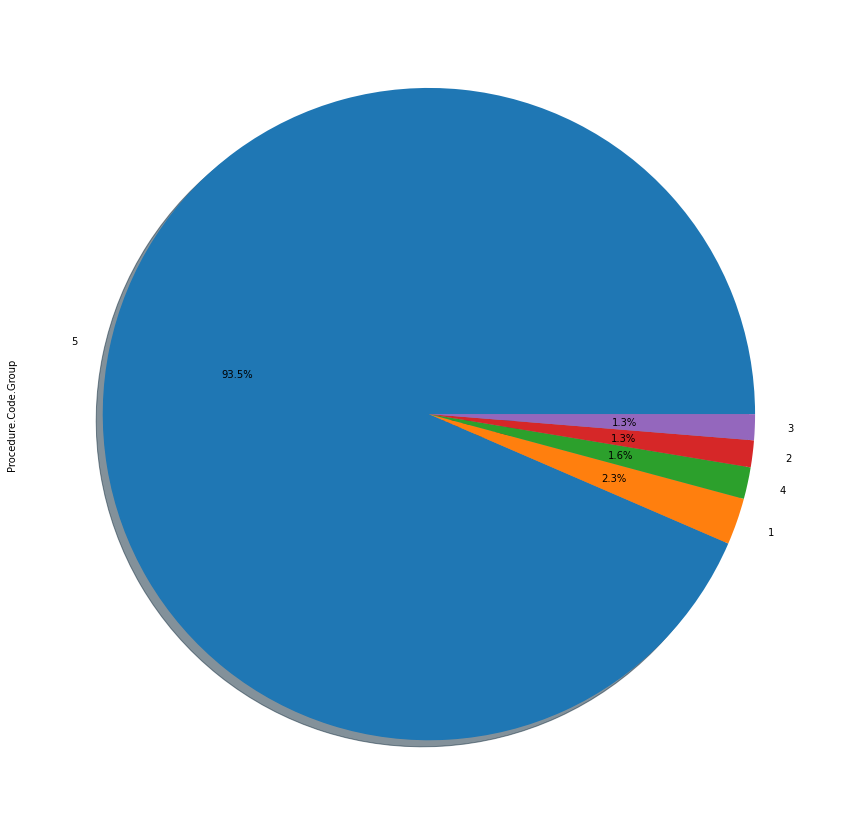

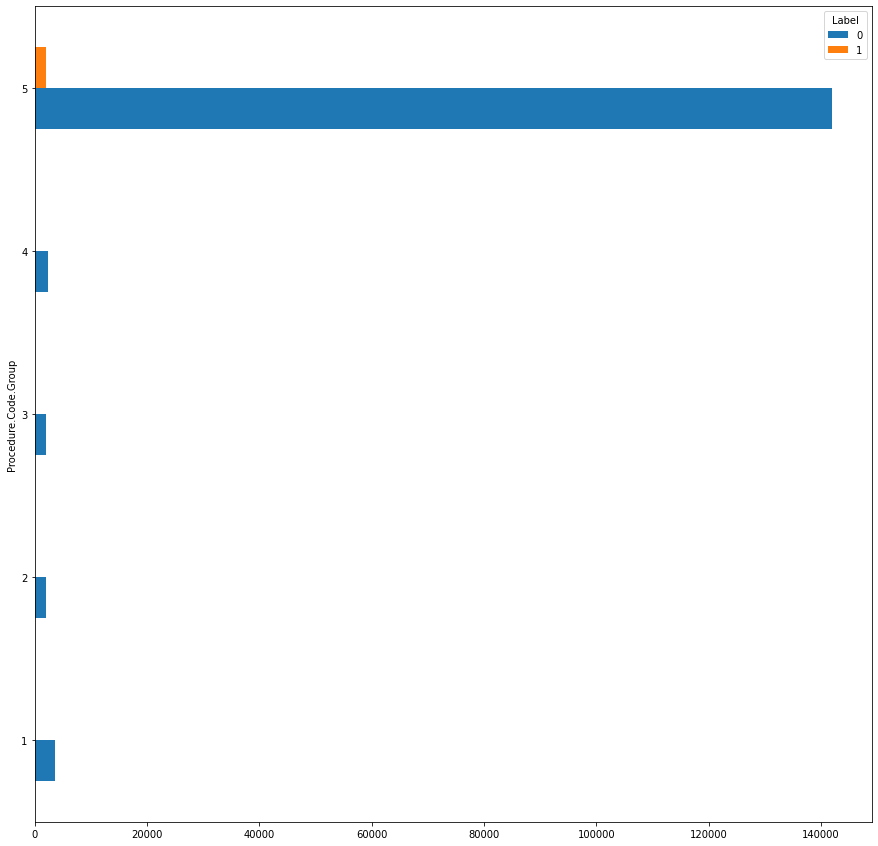

In [35]:
group_1 = ['85025']
group_2 = ['36415']
group_3 = ['80048']
group_4 = ['99283']
group_5 = ['Others']

df_data.loc[(df_data['Procedure.Code'].isin(group_1), 'Procedure.Code.Group')] = '1'
df_data.loc[(df_data['Procedure.Code'].isin(group_2), 'Procedure.Code.Group')] = '2'
df_data.loc[(df_data['Procedure.Code'].isin(group_3), 'Procedure.Code.Group')] = '3'
df_data.loc[(df_data['Procedure.Code'].isin(group_4), 'Procedure.Code.Group')] = '4'
df_data.loc[(df_data['Procedure.Code'].isin(group_5), 'Procedure.Code.Group')] = '5'

# Add the remaining to the Group 5
df_data.loc[(~df_data['Procedure.Code'].isin(group_1 + group_2 + group_3 + group_4 + group_5)), 'Procedure.Code.Group'] = '5'

#Lets see if the Binning/Grouping is done and what is the distribution of the Groups
print ('Distribution Of Procedure Code Group')
print (df_data['Procedure.Code.Group'].value_counts())

#lets look at the distribution of the Procedure.Code.Group across all the categories available
df_data['Procedure.Code.Group'].value_counts().plot.pie(autopct='%1.1f%%', shadow=True,figsize=(15, 15))

#Lets see the distribution of Procedure Code Group by Label
print (df_data.groupby(['Procedure.Code.Group','Label'])['Label'].count())


#lets look at the distribution of Revenue.Code by Label to understand which Revenue Codes contribute to the 
# Label 0 and which contribute to Label 1
pd.crosstab(df_data['Procedure.Code.Group'],df_data['Label']).plot.barh(figsize=(15, 15))

# This completes the Data Cleaning Activities and the new dataset file needs to be shared with the Client for confirmation before doing the Machine Learning Actvities.

## Correlation

,Srlno,Claim.Charge.Amount,Subscriber.Payment.Amount,Provider.Payment.Amount,Claim.Current.Status,Label,Revenue.Code.Group,Service.Code.Group,Diagnosis.Code.Group
Srlno,1.000000,0.045385,NaN,0.032408,0.117648,-0.053350,0.054111,0.212641,0.078296
Claim.Charge.Amount,0.045385,1.000000,NaN,0.183427,0.025944,0.051490,-0.023231,0.064916,0.006609
Subscriber.Payment.Amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Provider.Payment.Amount,0.032408,0.183427,NaN,1.000000,-0.022560,-0.007752,0.008159,-0.005507,0.020435
Claim.Current.Status,0.117648,0.025944,NaN,-0.022560,1.000000,-0.027587,0.047670,0.194610,0.017282
Label,-0.053350,0.051490,NaN,-0.007752,-0.027587,1.000000,-0.217728,-0.080579,-0.156162
Revenue.Code.Group,0.054111,-0.023231,NaN,0.008159,0.047670,-0.217728,1.000000,0.159008,-0.000973
Service.Code.Group,0.212641,0.064916,NaN,-0.005507,0.194610,-0.080579,0.159008,1.000000,0.000133
Diagnosis.Code.Group,0.078296,0.006609,NaN,0.020435,0.017282,-0.156162,-0.000973,0.000133,1.000000


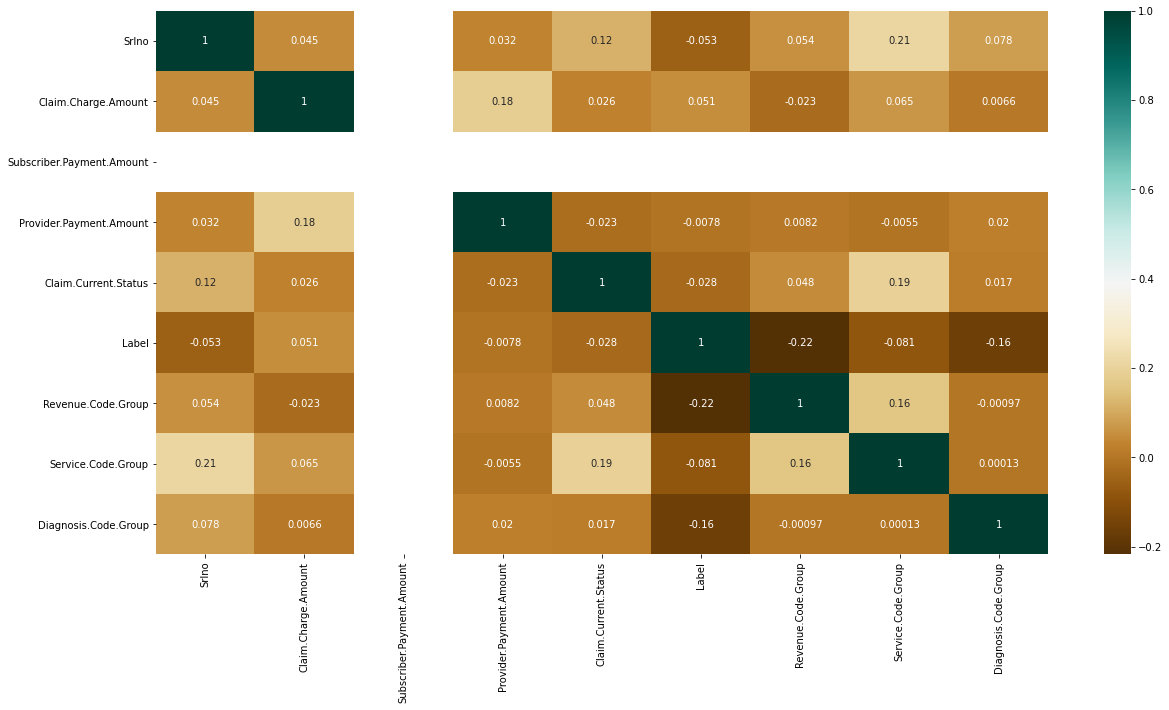

In [36]:
categorical_columns = ["Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group", "Claim.Current.Status", 'Label']
#categorical_columns = [ "Procedure.Code", "In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type", "Claim.Current.Status", "Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group", "Label"]

for col in categorical_columns: 
    df_data[col] = df_data[col].astype('int')
    
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
data_corr = df_data.corr()
sns.heatmap(data_corr, cmap="BrBG", annot=True)
data_corr

## Conclusion: All attributes are independent

##  Drop all useless columns – not required for Machine learning

In [37]:
columns_tobe_dropped = ['Srlno', 'Revenue.Code', 'Service.Code', 'Diagnosis.Code' , 'Claim.Number', 'Claim.Line.Number', 'Member.ID', 'Provider.ID', 'Network.ID', 'Agreement.ID','Procedure.Code','Place.Of.Service.Code']
df_data.drop(columns_tobe_dropped, axis = 1, inplace=True)

print(df_data.dtypes)

Claim.Charge.Amount               float64
Denial.Reason.Code                 object
In.Out.Of.Network                  object
Subscriber.Payment.Amount         float64
Provider.Payment.Amount           float64
Claim.Type                         object
Claim.Subscriber.Type              object
Claim.Current.Status                int64
Label                               int64
Claim.Number.Claim.Line.Number     object
Revenue.Code.Group                  int64
Service.Code.Group                  int64
Diagnosis.Code.Group                int64
Procedure.Code.Group               object
dtype: object


## Convert all the categorical columns type from object to category

In [38]:
categorical_columns = ["Claim.Number.Claim.Line.Number","Procedure.Code.Group", "Claim.Type", "Claim.Subscriber.Type", "Claim.Current.Status", "Revenue.Code.Group", "Service.Code.Group", "Diagnosis.Code.Group","In.Out.Of.Network", "Denial.Reason.Code", "Label"]

for col in categorical_columns: 
    df_data[col] = df_data[col].astype('category')
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153876 entries, 0 to 472558
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype   
---  ------                          --------------   -----   
 0   Claim.Charge.Amount             153876 non-null  float64 
 1   Denial.Reason.Code              1971 non-null    category
 2   In.Out.Of.Network               125725 non-null  category
 3   Subscriber.Payment.Amount       153876 non-null  float64 
 4   Provider.Payment.Amount         153876 non-null  float64 
 5   Claim.Type                      153876 non-null  category
 6   Claim.Subscriber.Type           153876 non-null  category
 7   Claim.Current.Status            153876 non-null  category
 8   Label                           153876 non-null  category
 9   Claim.Number.Claim.Line.Number  153876 non-null  category
 10  Revenue.Code.Group              153876 non-null  category
 11  Service.Code.Group              153876 non-null  category
 12  Di

In [39]:
print(df_data.groupby('Denial.Reason.Code')['Denial.Reason.Code'].count())
print(df_data['Denial.Reason.Code'].unique())

print(df_data.dtypes)

print(df_data['Label'].value_counts())
distLabels = (df_data['Label'].value_counts()/ df_data['Label'].count())*100
print(distLabels)

Denial.Reason.Code
F13    1068
J8G     382
JB8     128
JC9      49
JE1      33
JES      50
JF1       4
JF9      98
JG1      10
JO5     105
JPA      44
Name: Denial.Reason.Code, dtype: int64
[NaN, JB8, J8G, F13, JF1, ..., JO5, JG1, JPA, JC9, JF9]
Length: 12
Categories (11, object): [JB8, J8G, F13, JF1, ..., JG1, JPA, JC9, JF9]
Claim.Charge.Amount                float64
Denial.Reason.Code                category
In.Out.Of.Network                 category
Subscriber.Payment.Amount          float64
Provider.Payment.Amount            float64
Claim.Type                        category
Claim.Subscriber.Type             category
Claim.Current.Status              category
Label                             category
Claim.Number.Claim.Line.Number    category
Revenue.Code.Group                category
Service.Code.Group                category
Diagnosis.Code.Group              category
Procedure.Code.Group              category
dtype: object
0    151905
1      1971
Name: Label, dtype: int64
0    9

In [40]:
columns_tobe_dropped = ['Denial.Reason.Code', 'Claim.Number.Claim.Line.Number', 'Subscriber.Payment.Amount']
df_data.drop(columns_tobe_dropped, axis = 1, inplace=True)

print(df_data.dtypes)

Claim.Charge.Amount         float64
In.Out.Of.Network          category
Provider.Payment.Amount     float64
Claim.Type                 category
Claim.Subscriber.Type      category
Claim.Current.Status       category
Label                      category
Revenue.Code.Group         category
Service.Code.Group         category
Diagnosis.Code.Group       category
Procedure.Code.Group       category
dtype: object


## Label Encoding Categorical Values

In [41]:
# Label Encoding
print(df_data.groupby('In.Out.Of.Network')['In.Out.Of.Network'].count())

categorical_columns = ["In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type"]
for col in categorical_columns: 
    df_data[col] = df_data[col].astype('str')

lb_make = LabelEncoder()
df_data["Claim.Type"] = lb_make.fit_transform(df_data["Claim.Type"])
df_data["In.Out.Of.Network"] = lb_make.fit_transform(df_data["In.Out.Of.Network"])
df_data["Claim.Subscriber.Type"] = lb_make.fit_transform(df_data["Claim.Subscriber.Type"])

categorical_columns = ["In.Out.Of.Network", "Claim.Type", "Claim.Subscriber.Type"]
for col in categorical_columns: 
    df_data[col] = df_data[col].astype('category')

df_data.dtypes

print(df_data['Label'].value_counts())
distLabels = (df_data['Label'].value_counts()/ df_data['Label'].count())*100

In.Out.Of.Network
I    125398
O       327
Name: In.Out.Of.Network, dtype: int64
0    151905
1      1971
Name: Label, dtype: int64


In [0]:
# rearrange columns - so label will be in the last column
df_data = df_data[[ 'Claim.Charge.Amount', 
                   'In.Out.Of.Network', 
                   'Provider.Payment.Amount', 
                   'Claim.Type', 
                   'Claim.Subscriber.Type',
                   'Claim.Current.Status',
                   'Revenue.Code.Group', 
                   'Service.Code.Group', 
                   'Diagnosis.Code.Group', 
                   'Procedure.Code.Group', 
                   'Label',]]

In [43]:
df_data.info()
df_data.to_csv(cleanFile,index=False)
df_data_clean = df_data.copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153876 entries, 0 to 472558
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Claim.Charge.Amount      153876 non-null  float64 
 1   In.Out.Of.Network        153876 non-null  category
 2   Provider.Payment.Amount  153876 non-null  float64 
 3   Claim.Type               153876 non-null  category
 4   Claim.Subscriber.Type    153876 non-null  category
 5   Claim.Current.Status     153876 non-null  category
 6   Revenue.Code.Group       153876 non-null  category
 7   Service.Code.Group       153876 non-null  category
 8   Diagnosis.Code.Group     153876 non-null  category
 9   Procedure.Code.Group     153876 non-null  category
 10  Label                    153876 non-null  category
dtypes: category(9), float64(2)
memory usage: 9.8 MB


In [45]:
#import os
#os.remove(pklFile)
#
print("Pickling the Data Frame")
df_data.to_pickle(pklFile)
print("Pickled the Data Frame")


Pickling the Data Frame
Pickled the Data Frame


### Additional Visualizations

In [46]:
numerical_columns = ['Claim.Charge.Amount', 'Provider.Payment.Amount']      
categorical_columns = ['In.Out.Of.Network','Claim.Type','Claim.Subscriber.Type','Claim.Current.Status', 'Revenue.Code.Group','Service.Code.Group','Diagnosis.Code.Group','Procedure.Code.Group']                      
df_data = pd.read_pickle(pklFile)
print(df_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153876 entries, 0 to 472558
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   Claim.Charge.Amount      153876 non-null  float64 
 1   In.Out.Of.Network        153876 non-null  category
 2   Provider.Payment.Amount  153876 non-null  float64 
 3   Claim.Type               153876 non-null  category
 4   Claim.Subscriber.Type    153876 non-null  category
 5   Claim.Current.Status     153876 non-null  category
 6   Revenue.Code.Group       153876 non-null  category
 7   Service.Code.Group       153876 non-null  category
 8   Diagnosis.Code.Group     153876 non-null  category
 9   Procedure.Code.Group     153876 non-null  category
 10  Label                    153876 non-null  category
dtypes: category(9), float64(2)
memory usage: 4.8 MB
None


Plotting - visual Analysis

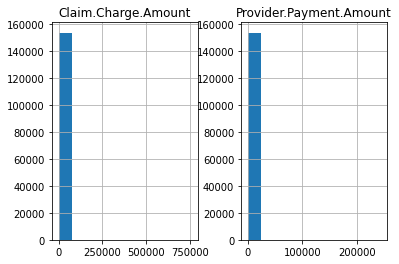

In [47]:
df_data.hist()
plt.show()

,Claim.Charge.Amount,In.Out.Of.Network,Provider.Payment.Amount,Claim.Type,Claim.Subscriber.Type,Claim.Current.Status,Revenue.Code.Group,Service.Code.Group,Diagnosis.Code.Group,Procedure.Code.Group
Claim.Charge.Amount,1.000000,-0.001736,0.183427,0.013667,-0.004527,0.025944,-0.023231,0.064916,0.006609,0.049682
In.Out.Of.Network,-0.001736,1.000000,-0.044046,0.134500,0.056015,0.764563,0.063523,0.254264,0.030774,0.009207
Provider.Payment.Amount,0.183427,-0.044046,1.000000,-0.163999,-0.002735,-0.022560,0.008159,-0.005507,0.020435,0.021519
Claim.Type,0.013667,0.134500,-0.163999,1.000000,0.008692,0.063841,-0.158391,-0.025535,0.028455,-0.057663
Claim.Subscriber.Type,-0.004527,0.056015,-0.002735,0.008692,1.000000,0.042039,0.098770,0.052617,-0.002272,0.007069
Claim.Current.Status,0.025944,0.764563,-0.022560,0.063841,0.042039,1.000000,0.047670,0.194610,0.017282,0.020741
Revenue.Code.Group,-0.023231,0.063523,0.008159,-0.158391,0.098770,0.047670,1.000000,0.159008,-0.000973,0.000026
Service.Code.Group,0.064916,0.254264,-0.005507,-0.025535,0.052617,0.194610,0.159008,1.000000,0.000133,-0.016442
Diagnosis.Code.Group,0.006609,0.030774,0.020435,0.028455,-0.002272,0.017282,-0.000973,0.000133,1.000000,0.035746
Procedure.Code.Group,0.049682,0.009207,0.021519,-0.057663,0.007069,0.020741,0.000026,-0.016442,0.035746,1.000000


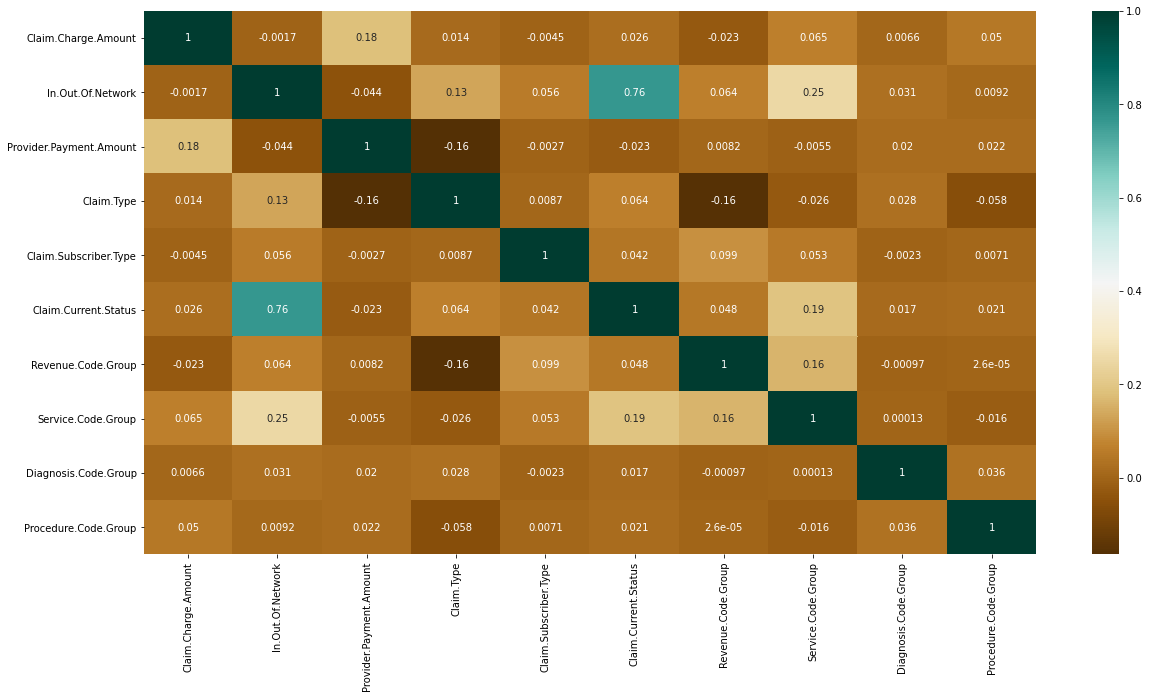

In [48]:
for col in categorical_columns: 
    df_data[col] = df_data[col].astype('int')
    
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
data_corr = df_data.corr()
sns.heatmap(data_corr, cmap="BrBG", annot=True)
data_corr

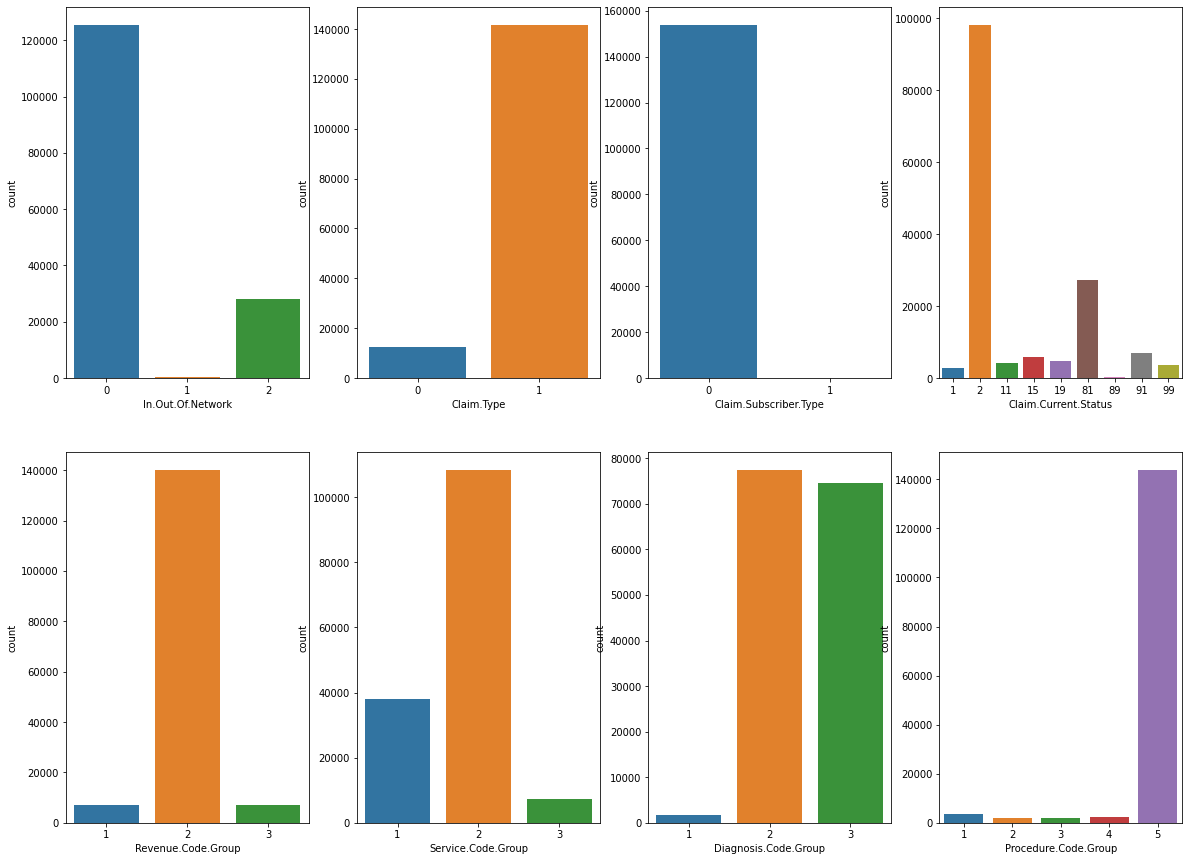

In [50]:
# Analyzing Categorical Variables

fig, ax = plt.subplots(2, 4, figsize=(20, 15))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    sns.countplot(df_data[variable], ax=subplot) 

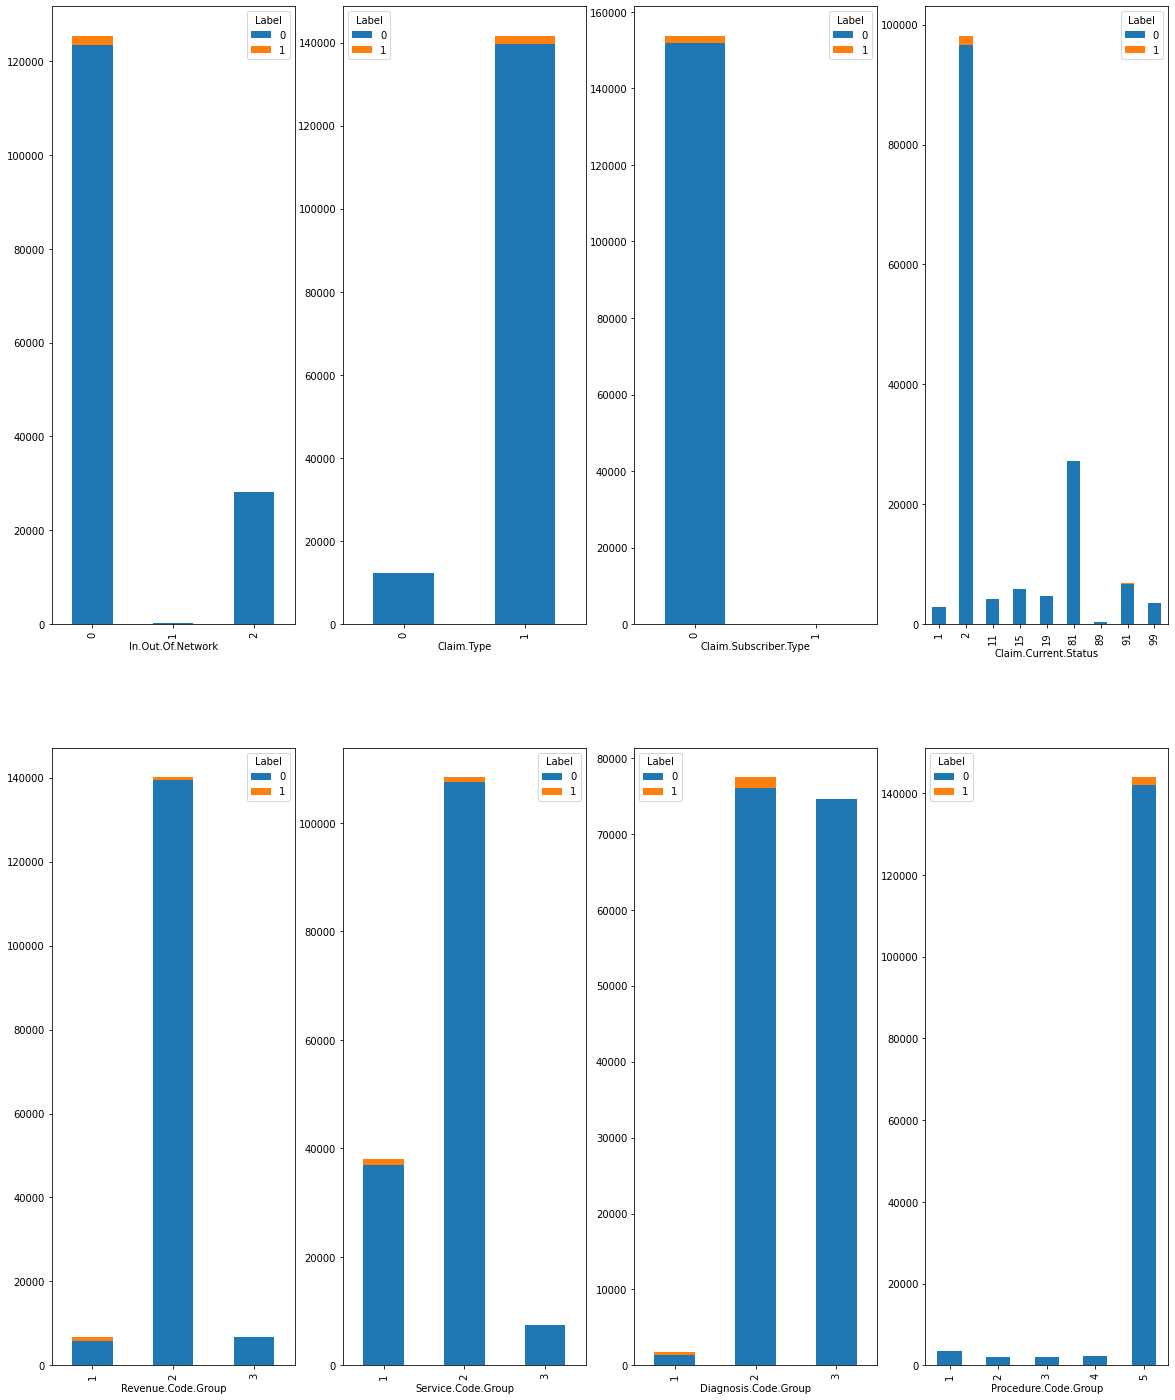

In [51]:
# Compare categorical variable with 'Label'
fig, ax = plt.subplots(2, 4, figsize=(20, 25))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    pd.crosstab(df_data[variable], df_data['Label']).plot(kind='bar', ax=subplot, stacked=True)

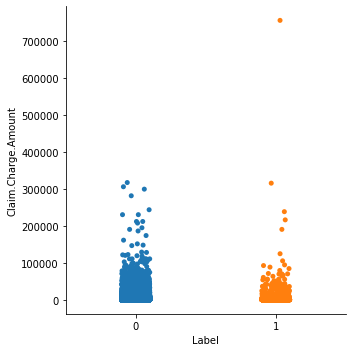

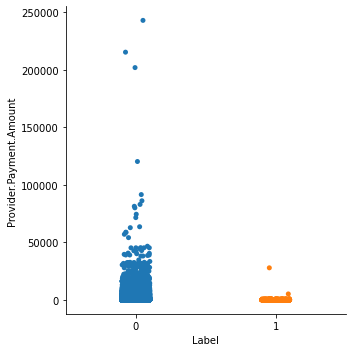

In [52]:
sns.catplot(x='Label', y='Claim.Charge.Amount', data=df_data)
sns.catplot(x='Label', y='Provider.Payment.Amount', data=df_data)


,Claim.Charge.Amount,In.Out.Of.Network,Provider.Payment.Amount,Claim.Type,Claim.Subscriber.Type,Claim.Current.Status,Revenue.Code.Group,Service.Code.Group,Diagnosis.Code.Group,Procedure.Code.Group
Claim.Charge.Amount,1.000000,-0.001736,0.183427,0.013667,-0.004527,0.025944,-0.023231,0.064916,0.006609,0.049682
In.Out.Of.Network,-0.001736,1.000000,-0.044046,0.134500,0.056015,0.764563,0.063523,0.254264,0.030774,0.009207
Provider.Payment.Amount,0.183427,-0.044046,1.000000,-0.163999,-0.002735,-0.022560,0.008159,-0.005507,0.020435,0.021519
Claim.Type,0.013667,0.134500,-0.163999,1.000000,0.008692,0.063841,-0.158391,-0.025535,0.028455,-0.057663
Claim.Subscriber.Type,-0.004527,0.056015,-0.002735,0.008692,1.000000,0.042039,0.098770,0.052617,-0.002272,0.007069
Claim.Current.Status,0.025944,0.764563,-0.022560,0.063841,0.042039,1.000000,0.047670,0.194610,0.017282,0.020741
Revenue.Code.Group,-0.023231,0.063523,0.008159,-0.158391,0.098770,0.047670,1.000000,0.159008,-0.000973,0.000026
Service.Code.Group,0.064916,0.254264,-0.005507,-0.025535,0.052617,0.194610,0.159008,1.000000,0.000133,-0.016442
Diagnosis.Code.Group,0.006609,0.030774,0.020435,0.028455,-0.002272,0.017282,-0.000973,0.000133,1.000000,0.035746
Procedure.Code.Group,0.049682,0.009207,0.021519,-0.057663,0.007069,0.020741,0.000026,-0.016442,0.035746,1.000000


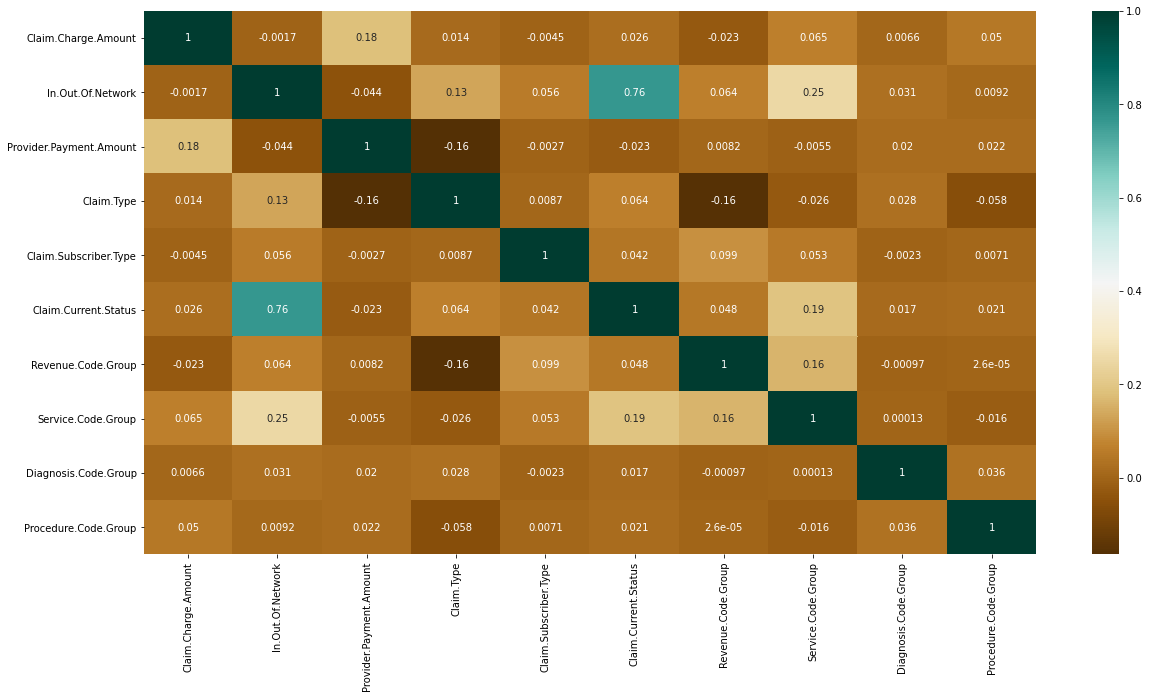

In [53]:
# Finding the relations between the variables.
plt.figure(figsize=(20,10))
data_corr = df_data.corr()
sns.heatmap(data_corr, cmap="BrBG", annot=True)
data_corr

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3717: UserWarning: catplot is a figure-level function and does not accept target axes. You may wish to try stripplot
  warnings.warn(msg, UserWarning)


AxesSubplot(0.125,0.125;0.227941x0.755)
AxesSubplot(0.398529,0.125;0.227941x0.755)


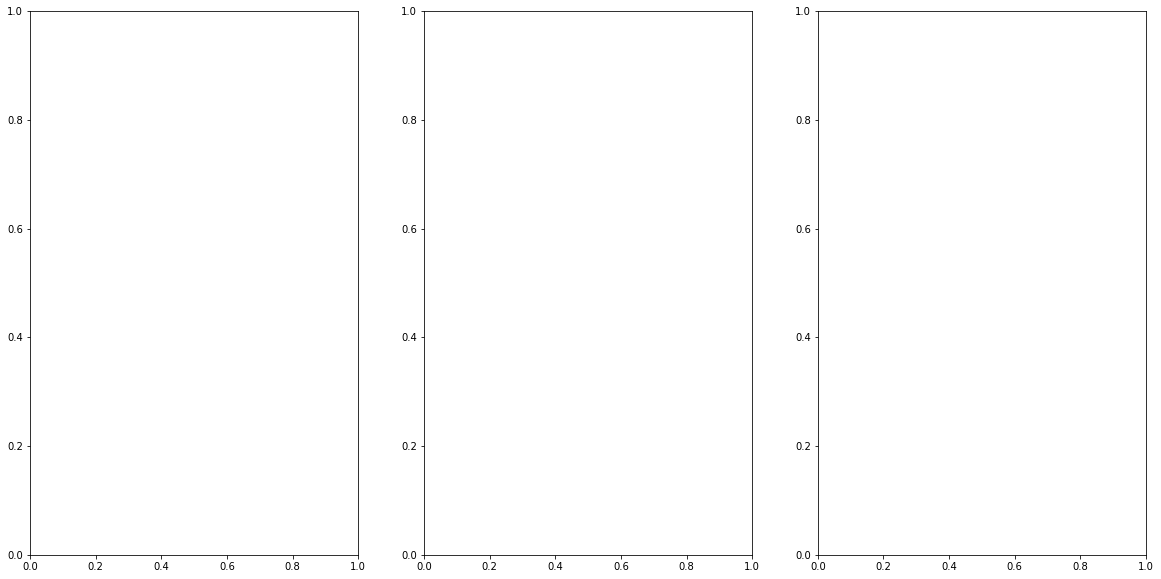

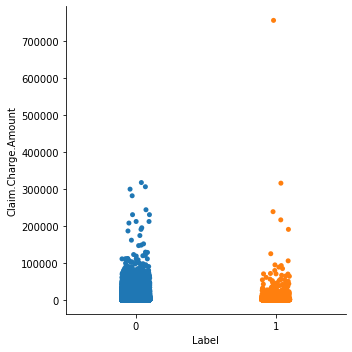

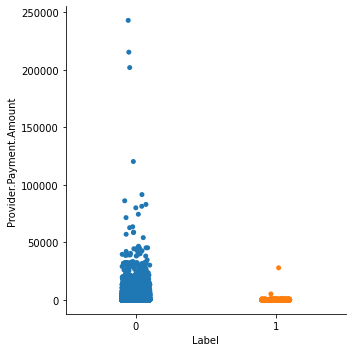

In [54]:
fig, ax = plt.subplots(1, 3, figsize=(20, 10))
for variable, subplot in zip(numerical_columns, ax.flatten()):
    #sns.countplot(df_data[variable], ax=subplot) 
    sns.catplot(x="Label", y=variable, data=df_data, ax=subplot)
    print(subplot)

In [55]:
na_count = df_data["Provider.Payment.Amount"].sum()
print(na_count, df_data["Provider.Payment.Amount"].count())
print(df_data["Provider.Payment.Amount"][0])
print(df_data["Provider.Payment.Amount"].isin([0.0]).sum())

24372424.751549996 153876
15036.21
140909


In [0]:
fig, ax = plt.subplots(1, 2, figsize=(20, 25))
for variable, subplot in zip(numerical_columns, ax.flatten()):
    pd.crosstab(df_data[variable], df_data['Label']).plot(kind='bar', ax=subplot, stacked=True)

In [0]:
df_data.corr()

,Claim.Charge.Amount,Provider.Payment.Amount
Claim.Charge.Amount,1.000000,0.183466
Provider.Payment.Amount,0.183466,1.000000


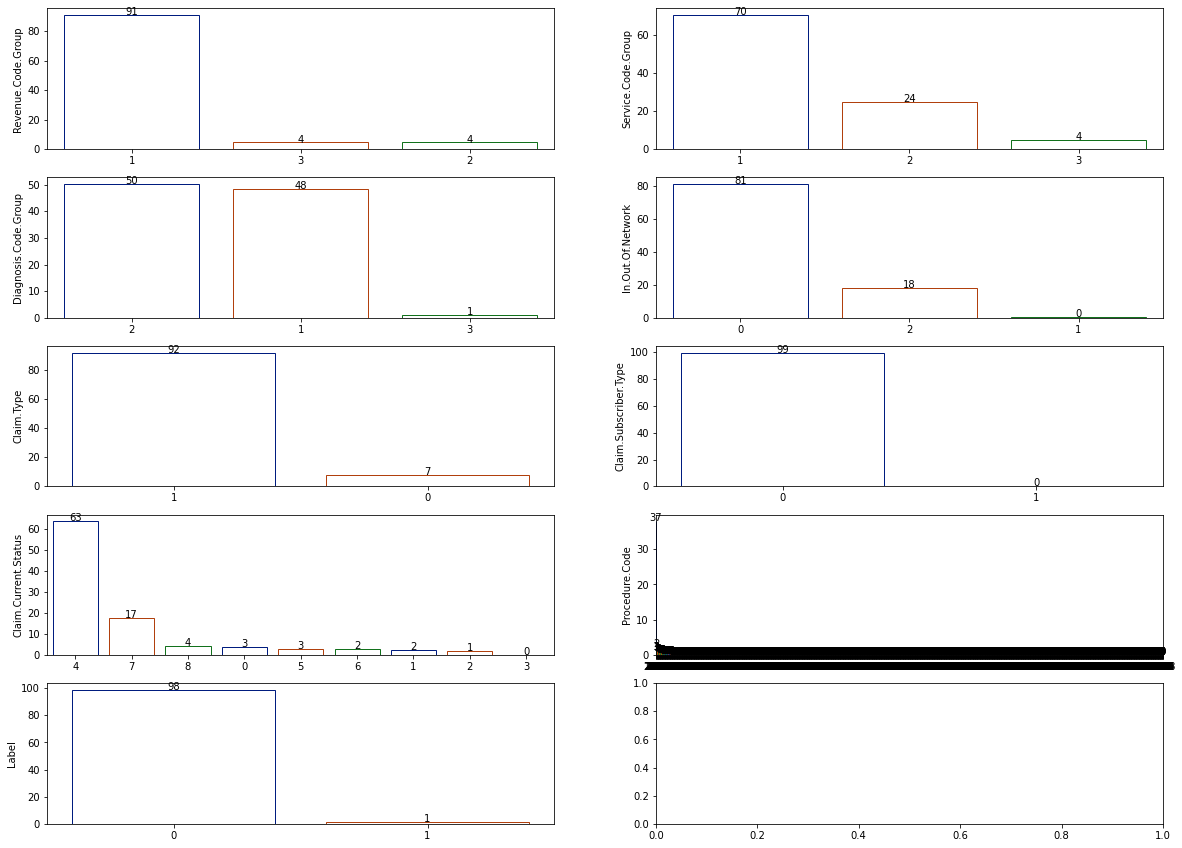

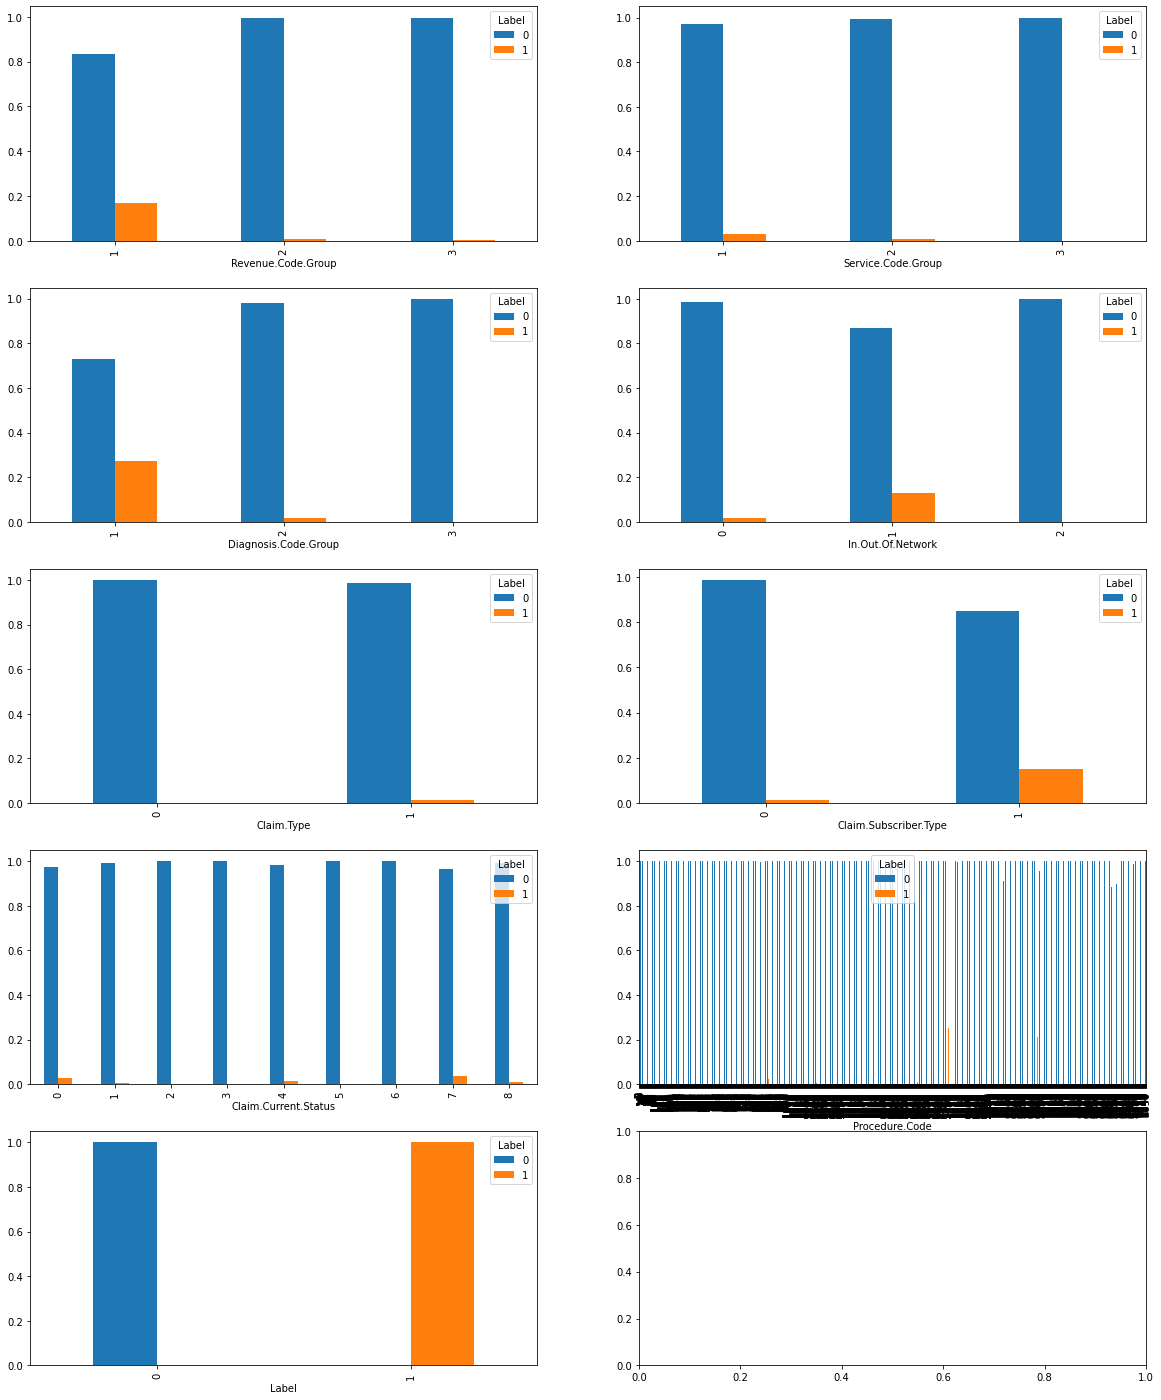

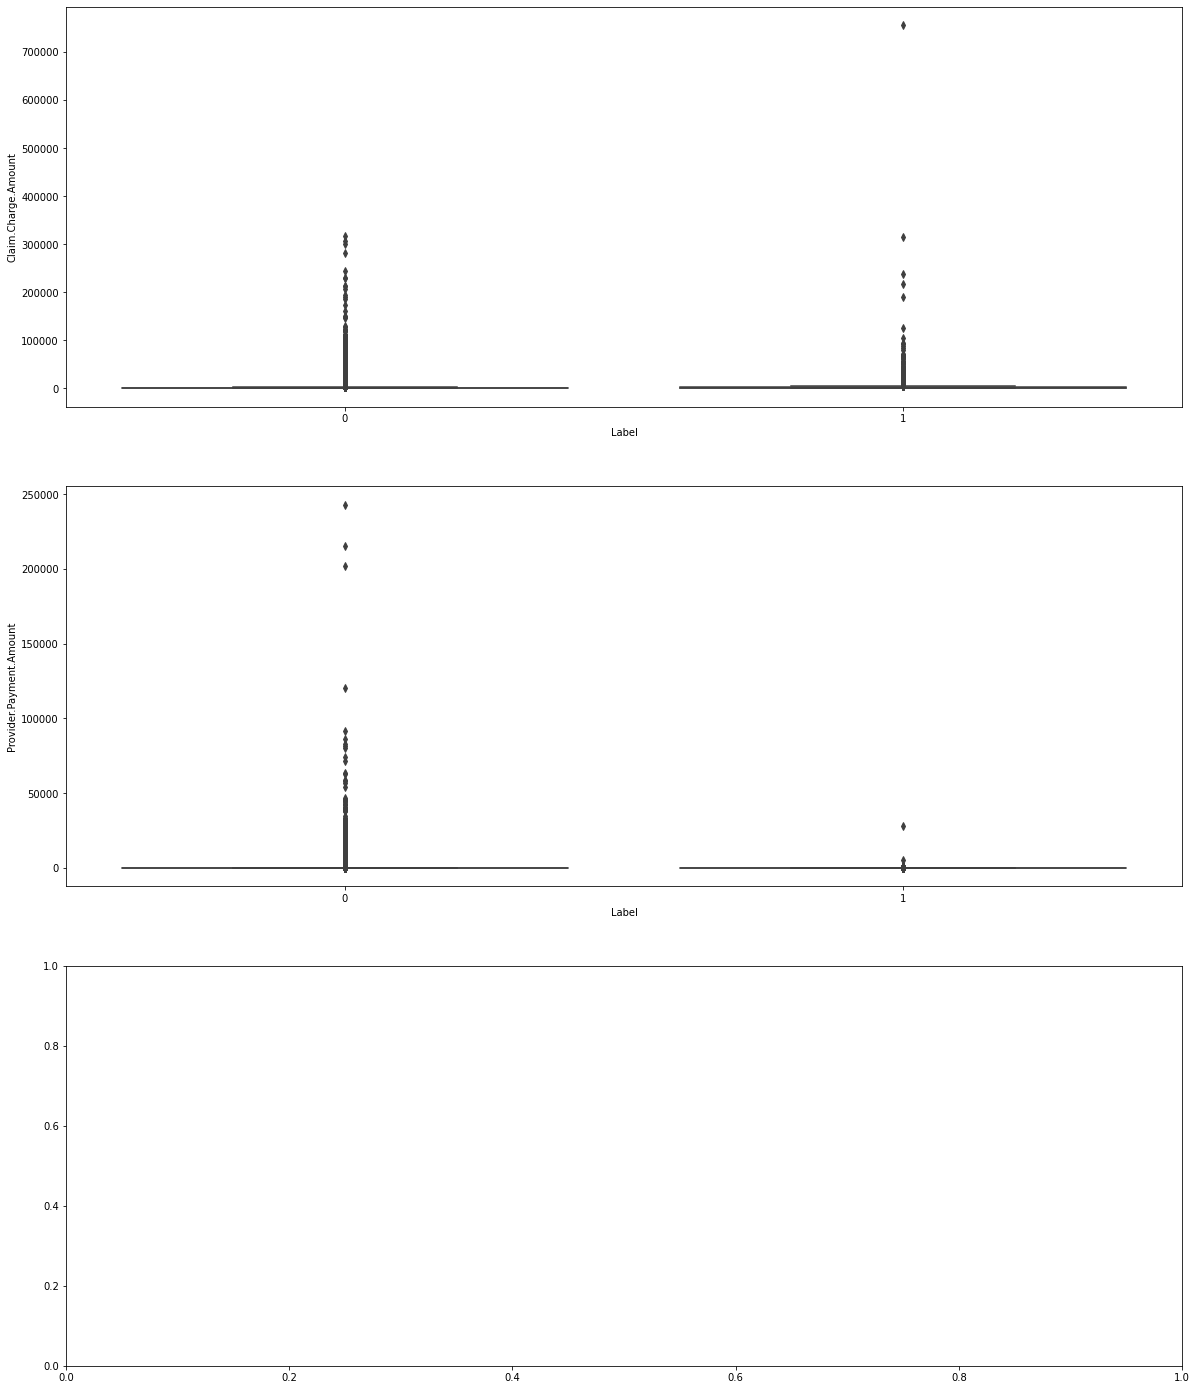

In [0]:
# Where to save the figures -  Incase this does not work you can comment this entire cell
#PROJECT_ROOT_DIR = "."
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
#os.makedirs(IMAGES_PATH, exist_ok=True)
IMAGES_PATH='/content/gdrive/My Drive/capstone-project/output_data/'

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

#print('Histogram of All Numeric Values')
#df_data.hist(bins=50,figsize=(20,20))
#save_fig("Histogram of All Numeric Values")



#  - Incase this does not work you can comment this entire cell
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)



# Analyzing Categorical Variables
# Incase this does not work you can comment this entire cell

categorical_columns = ["Revenue.Code.Group", 
                       "Service.Code.Group", 
                       "Diagnosis.Code.Group",
                       "In.Out.Of.Network", 
                       "Claim.Type", 
                       "Claim.Subscriber.Type", 
                       "Claim.Current.Status", 
                       "Procedure.Code", 
                       "Label"]


fig, ax = plt.subplots(5, 2, figsize=(20, 15))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    #myplot = sns.countplot(df_data[variable], ax=subplot)
    myplot = sns.barplot(x=df_data[variable].unique(), y=100*df_data[variable].value_counts()/len(df_data[variable]),edgecolor=sns.color_palette("dark", 3),facecolor=(0, 0, 0, 0),ax=subplot)
    show_values_on_bars(myplot, "v", 0.5)

# Incase this does not work you can comment this entire cell

categorical_columns = ["Revenue.Code.Group", 
                       "Service.Code.Group", 
                       "Diagnosis.Code.Group",
                       "In.Out.Of.Network", 
                       "Claim.Type", 
                       "Claim.Subscriber.Type", 
                       "Claim.Current.Status", 
                       "Procedure.Code", 
                       "Label"]

                
# Compare categorical variable with 'Label'
fig, ax = plt.subplots(5, 2, figsize=(20, 25))
for variable, subplot in zip(categorical_columns, ax.flatten()):
    myplot = pd.crosstab(df_data[variable], df_data['Label'],normalize='index').plot(kind='bar', ax=subplot, stacked=False)


# Incase this does not work you can comment this entire cell

numerical_columns = ['Claim.Charge.Amount', 'Provider.Payment.Amount']
fig, ax = plt.subplots(3, 1, figsize=(20, 25))
for variable, subplot in zip(numerical_columns, ax.flatten()):
    myplot = sns.boxplot(x='Label', y=variable, data=df_data,ax=subplot)
